# Data Preprocessing, Explorative Data Analysis (EDA) and Machine Learning

In this Jupyter Notebook, we will embark on a comprehensive journey through data handling, analysis, and modeling using a dataset comprising football match and weather data retrieved from a MySQL database. Initially, we will merge and organize the datasets to create a unified view of the data. Following this, we will conduct thorough data cleansing to ensure data quality and perform exploratory data analysis (EDA) to uncover insights and patterns. The next stages involve feature engineering to prepare the data for machine learning. We will then develop and train a predictive model, evaluate its performance, and fine-tune it through hyperparameter adjustments. Finally, we will utilize our model to predict outcomes of future football matches, providing actionable insights and demonstrating the practical application of our analytical endeavors.

## 1. Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
from mysql.connector import Error
import folium
from folium.plugins import HeatMap
import openmeteo_requests # Custom module for managing requests to the OpenMeteo API.
import requests_cache # Caches the responses of HTTP requests to enhance efficiency and reduce load times.
from retry_requests import retry # Provides a mechanism to automatically retry HTTP requests on failure.
import time # Allows us to use functionality related to time, such as delays and timestamp calculations.

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix, classification_report, auc
from sklearn.preprocessing import StandardScaler

## 2. Get Football Matches Data from MySQL and Store in Dataframe

In [3]:
try:
    # Establish a connection to the MySQL database using provided credentials.
    connection = mysql.connector.connect(
        host='localhost',
        database='adsfootball',
        user='root',
        password='abcabc123'
    )

    # Check if the database connection was successfully established
    if connection.is_connected():
        # SQL query to fetch all records from the 'matches' table
        query = "SELECT * FROM matches"
        # Execute the SQL query and store the result in a DataFrame for easy data manipulation
        all_matches_df = pd.read_sql_query(query, connection)
        
except Error as e:
    # Print any errors encountered during the database operation
    print(f"Error: {e}")

finally:
    # Ensure the database connection is closed to free system resources
    if connection.is_connected():
        connection.close()
        print("MySQL connection is closed")

MySQL connection is closed


C:\Users\Besfort\AppData\Local\Temp\ipykernel_20200\1287155837.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  all_matches_df = pd.read_sql_query(query, connection)


In [4]:
all_matches_df.head()

,id,date,time,comp,round,day,venue,result,gf,ga,...,dist,fk,pk,pkatt,season,team,latitude,longitude,city,stadium
0,1,2023-08-19,15:30,Bundesliga,Matchweek 1,Sat,Home,W,3.0,2.0,...,19.0,0.0,0,0,2024,Bayer Leverkusen,51.0383,7.00221,Leverkusen,BayArena
1,2,2023-08-26,18:30,Bundesliga,Matchweek 2,Sat,Away,W,3.0,0.0,...,15.8,0.0,0,0,2024,Bayer Leverkusen,51.1746,6.38546,Mönchengladbach,Borussia-Park
2,3,2023-09-02,15:30,Bundesliga,Matchweek 3,Sat,Home,W,5.0,1.0,...,17.3,1.0,0,0,2024,Bayer Leverkusen,51.0383,7.00221,Leverkusen,BayArena
3,4,2023-09-15,20:30,Bundesliga,Matchweek 4,Fri,Away,D,2.0,2.0,...,20.7,1.0,1,1,2024,Bayer Leverkusen,48.2188,11.62480,Munich,Allianz Arena
4,5,2023-09-24,15:30,Bundesliga,Matchweek 5,Sun,Home,W,4.0,1.0,...,16.7,0.0,1,1,2024,Bayer Leverkusen,51.0383,7.00221,Leverkusen,BayArena


In [5]:
all_matches_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2358 entries, 0 to 2357
Data columns (total 31 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          2358 non-null   int64  
 1   date        2358 non-null   object 
 2   time        2358 non-null   object 
 3   comp        2358 non-null   object 
 4   round       2358 non-null   object 
 5   day         2358 non-null   object 
 6   venue       2358 non-null   object 
 7   result      2358 non-null   object 
 8   gf          2358 non-null   float64
 9   ga          2358 non-null   float64
 10  opponent    2358 non-null   object 
 11  xg          2356 non-null   float64
 12  xga         2356 non-null   float64
 13  poss        2358 non-null   float64
 14  attendance  1776 non-null   float64
 15  captain     2358 non-null   object 
 16  formation   2358 non-null   object 
 17  referee     2358 non-null   object 
 18  notes       2 non-null      object 
 19  sh          2358 non-null  

## 3. Get Weather Data from MySQL and Store in Dataframe

In [6]:
try:
    # Establish a connection to the MySQL database using the provided credentials.
    connection = mysql.connector.connect(
        host='localhost',
        database='adsfootball',
        user='root',
        password='abcabc123'
    )

    # Check if the database connection was successfully established
    if connection.is_connected():
        # Define an SQL query to retrieve all records from the 'weather' table
        query = "SELECT * FROM weather"
        # Execute the SQL query and store the result in a DataFrame for further analysis
        weather_df = pd.read_sql(query, connection)
        
except Error as e:
    # Handle any errors that occur during the database operation and print the error message
    print(f"Error: {e}")

finally:
    # Ensure the database connection is closed to free system resources
    if connection.is_connected():
        connection.close()
        print("MySQL connection is closed")

MySQL connection is closed


C:\Users\Besfort\AppData\Local\Temp\ipykernel_20200\1484147469.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  weather_df = pd.read_sql(query, connection)


In [7]:
weather_df.head()

,id,date,latitude,longitude,weather_code,mean_temperature,precipitation_sum,rain_sum,snowfall_sum
0,1,2023-08-19,51.0383,7.00221,63.0,23.7362,5.3,5.3,0.0
1,2,2023-08-26,51.1746,6.38546,53.0,17.3998,1.8,1.8,0.0
2,3,2023-09-02,51.0383,7.00221,51.0,17.8883,0.2,0.2,0.0
3,4,2023-09-15,48.2188,11.62480,3.0,17.1803,0.0,0.0,0.0
4,5,2023-09-24,51.0383,7.00221,1.0,13.6737,0.0,0.0,0.0


In [8]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2358 entries, 0 to 2357
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 2358 non-null   int64  
 1   date               2358 non-null   object 
 2   latitude           2358 non-null   float64
 3   longitude          2358 non-null   float64
 4   weather_code       2358 non-null   float64
 5   mean_temperature   2358 non-null   float64
 6   precipitation_sum  2358 non-null   float64
 7   rain_sum           2358 non-null   float64
 8   snowfall_sum       2358 non-null   float64
dtypes: float64(7), int64(1), object(1)
memory usage: 165.9+ KB


## 4. Data Organization

After successfully loading our datasets, the next step involves merging the weather data with the football match data. This crucial integration combines key information from both datasets, facilitating a detailed analysis of how weather conditions may influence match outcomes.

### 4.1 Merge Datasets

In [9]:
full_matches_dataset = all_matches_df.merge(weather_df[['id', 'weather_code', 'mean_temperature', 'precipitation_sum', 'rain_sum', 'snowfall_sum']], on='id', how='left')
full_matches_dataset.head()

,id,date,time,comp,round,day,venue,result,gf,ga,...,team,latitude,longitude,city,stadium,weather_code,mean_temperature,precipitation_sum,rain_sum,snowfall_sum
0,1,2023-08-19,15:30,Bundesliga,Matchweek 1,Sat,Home,W,3.0,2.0,...,Bayer Leverkusen,51.0383,7.00221,Leverkusen,BayArena,63.0,23.7362,5.3,5.3,0.0
1,2,2023-08-26,18:30,Bundesliga,Matchweek 2,Sat,Away,W,3.0,0.0,...,Bayer Leverkusen,51.1746,6.38546,Mönchengladbach,Borussia-Park,53.0,17.3998,1.8,1.8,0.0
2,3,2023-09-02,15:30,Bundesliga,Matchweek 3,Sat,Home,W,5.0,1.0,...,Bayer Leverkusen,51.0383,7.00221,Leverkusen,BayArena,51.0,17.8883,0.2,0.2,0.0
3,4,2023-09-15,20:30,Bundesliga,Matchweek 4,Fri,Away,D,2.0,2.0,...,Bayer Leverkusen,48.2188,11.62480,Munich,Allianz Arena,3.0,17.1803,0.0,0.0,0.0
4,5,2023-09-24,15:30,Bundesliga,Matchweek 5,Sun,Home,W,4.0,1.0,...,Bayer Leverkusen,51.0383,7.00221,Leverkusen,BayArena,1.0,13.6737,0.0,0.0,0.0


In [10]:
full_matches_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2358 entries, 0 to 2357
Data columns (total 36 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 2358 non-null   int64  
 1   date               2358 non-null   object 
 2   time               2358 non-null   object 
 3   comp               2358 non-null   object 
 4   round              2358 non-null   object 
 5   day                2358 non-null   object 
 6   venue              2358 non-null   object 
 7   result             2358 non-null   object 
 8   gf                 2358 non-null   float64
 9   ga                 2358 non-null   float64
 10  opponent           2358 non-null   object 
 11  xg                 2356 non-null   float64
 12  xga                2356 non-null   float64
 13  poss               2358 non-null   float64
 14  attendance         1776 non-null   float64
 15  captain            2358 non-null   object 
 16  formation          2358 

### 4.2 Categorize Weather Conditions Using WMO Codes

After successfully merging both datasets, our next task is to categorize the weather codes into comprehensive values as outlined below:

- **Sunny or Clear**: Codes 0-19 (conditions without precipitation and significant cloud cover)
- **Cloudy**: Codes 20-29 and 40-49 (conditions with previous precipitation, fog, or thunderstorms that have ceased and specifically for fog or ice fog at observation)
- **Rainy**: Codes 50-69, 80-82, 91-92, 95-97, 99 (various forms of drizzle, rain, rain showers and thunderstorms with rain) 
- **Snowy**: Codes 70-79, 83-86, 93-94 (various forms of snowfall, snow showers and thunderstorms with snow)

For a complete reference of these codes, please visit [WMO Codes Table](https://www.nodc.noaa.gov/archive/arc0021/0002199/1.1/data/0-data/HTML/WMO-CODE/WMO4677.HTM).

In [11]:
# Function to categorize weather codes
def categorize_weather(code):
    if code in range(0, 20):
        return 'Clear'
    elif code in range(20, 30) or code in range(40, 50):
        return 'Cloudy'
    elif code in range(50, 70) or code in range(80, 83) or code in range(91, 93) or code in range(95, 98) or code == 99:
        return 'Rainy'
    elif code in range(70, 80) or code in range(83, 87) or code in range(93, 95):
        return 'Snowy'
    else:
        return 'Other'

# Apply the function to the weather_code column
full_matches_dataset['weather_category'] = full_matches_dataset['weather_code'].apply(categorize_weather)
full_matches_dataset.head()

,id,date,time,comp,round,day,venue,result,gf,ga,...,latitude,longitude,city,stadium,weather_code,mean_temperature,precipitation_sum,rain_sum,snowfall_sum,weather_category
0,1,2023-08-19,15:30,Bundesliga,Matchweek 1,Sat,Home,W,3.0,2.0,...,51.0383,7.00221,Leverkusen,BayArena,63.0,23.7362,5.3,5.3,0.0,Rainy
1,2,2023-08-26,18:30,Bundesliga,Matchweek 2,Sat,Away,W,3.0,0.0,...,51.1746,6.38546,Mönchengladbach,Borussia-Park,53.0,17.3998,1.8,1.8,0.0,Rainy
2,3,2023-09-02,15:30,Bundesliga,Matchweek 3,Sat,Home,W,5.0,1.0,...,51.0383,7.00221,Leverkusen,BayArena,51.0,17.8883,0.2,0.2,0.0,Rainy
3,4,2023-09-15,20:30,Bundesliga,Matchweek 4,Fri,Away,D,2.0,2.0,...,48.2188,11.62480,Munich,Allianz Arena,3.0,17.1803,0.0,0.0,0.0,Clear
4,5,2023-09-24,15:30,Bundesliga,Matchweek 5,Sun,Home,W,4.0,1.0,...,51.0383,7.00221,Leverkusen,BayArena,1.0,13.6737,0.0,0.0,0.0,Clear


In [12]:
full_matches_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2358 entries, 0 to 2357
Data columns (total 37 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 2358 non-null   int64  
 1   date               2358 non-null   object 
 2   time               2358 non-null   object 
 3   comp               2358 non-null   object 
 4   round              2358 non-null   object 
 5   day                2358 non-null   object 
 6   venue              2358 non-null   object 
 7   result             2358 non-null   object 
 8   gf                 2358 non-null   float64
 9   ga                 2358 non-null   float64
 10  opponent           2358 non-null   object 
 11  xg                 2356 non-null   float64
 12  xga                2356 non-null   float64
 13  poss               2358 non-null   float64
 14  attendance         1776 non-null   float64
 15  captain            2358 non-null   object 
 16  formation          2358 

### 4.3 Categorize Time

In [13]:
# Convert 'time' to datetime to just extract the hour
full_matches_dataset['time'] = pd.to_datetime(full_matches_dataset['time'], format='%H:%M').dt.hour

# Define a function to categorize times into different parts of the day
def categorize_time(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

# Apply the function to the 'time' column
full_matches_dataset['time_of_day'] = full_matches_dataset['time'].apply(categorize_time)

### 4.4 Organize the Columns Order and Change Names

In [14]:
columns_ordered = [
    'id', 'date', 'time', 'time_of_day', 'season', 'comp', 'round', 'day',
    'team', 'opponent', 'venue', 'captain', 'formation',
    'result', 'gf', 'ga', 'xg', 'xga', 'sh', 'sot', 'poss', 'fk', 'pk',
    'dist', 'weather_category', 'mean_temperature', 'precipitation_sum', 'rain_sum', 'snowfall_sum',
    'stadium', 'city', 'latitude', 'longitude', 'weather_code',
    'attendance', 'referee', 'notes'
]

# Change order of the dataframe
full_matches_dataset = full_matches_dataset[columns_ordered]

In [15]:
full_matches_dataset.head()

,id,date,time,time_of_day,season,comp,round,day,team,opponent,...,rain_sum,snowfall_sum,stadium,city,latitude,longitude,weather_code,attendance,referee,notes
0,1,2023-08-19,15,Afternoon,2024,Bundesliga,Matchweek 1,Sat,Bayer Leverkusen,RB Leipzig,...,5.3,0.0,BayArena,Leverkusen,51.0383,7.00221,63.0,29464.0,Felix Brych,None
1,2,2023-08-26,18,Evening,2024,Bundesliga,Matchweek 2,Sat,Bayer Leverkusen,Monchengladbach,...,1.8,0.0,Borussia-Park,Mönchengladbach,51.1746,6.38546,53.0,54042.0,Christian Dingert,None
2,3,2023-09-02,15,Afternoon,2024,Bundesliga,Matchweek 3,Sat,Bayer Leverkusen,Darmstadt 98,...,0.2,0.0,BayArena,Leverkusen,51.0383,7.00221,51.0,29653.0,Sven Jablonski,None
3,4,2023-09-15,20,Evening,2024,Bundesliga,Matchweek 4,Fri,Bayer Leverkusen,Bayern Munich,...,0.0,0.0,Allianz Arena,Munich,48.2188,11.62480,3.0,75000.0,Daniel Schlager,None
4,5,2023-09-24,15,Afternoon,2024,Bundesliga,Matchweek 5,Sun,Bayer Leverkusen,Heidenheim,...,0.0,0.0,BayArena,Leverkusen,51.0383,7.00221,1.0,29557.0,Christian Dingert,None


In [16]:
# Change column names to more meaningful names
full_matches_dataset.columns = [
    'id', 'date', 'time', 'time_of_day', 'season', 'competition', 'round', 'match_day',
    'team', 'opponent', 'venue', 'captain', 'formation',
    'result', 'goals_for', 'goals_against', 'expected_goals', 'expected_goals_against', 'shots', 'shots_on_target', 'possession', 'free_kicks', 'penalties',
    'distance_covered', 'weather_category', 'mean_temperature', 'precipitation_sum', 'rain_sum', 'snowfall_sum',
    'stadium', 'city', 'latitude', 'longitude', 'weather_code',
    'attendance', 'referee', 'notes'
]

### 4.5 Column Descriptions for the Dataset

1. **date**: The date on which the match was played.
2. **time**: The kickoff time of the match.
3. **time_of_day**: Category of the time of the match.
4. **season**: The football season year during which the match was played.
5. **competition**: The name of the league or competition (e.g., Bundesliga).
6. **round**: Indicates the matchweek number within the season.
7. **match_day**: Weekday of the game.
8. **team**: The name of the team from whose perspective the match data is recorded.
9. **opponent**: The name of the opposing team.
10. **venue**: Whether the team was playing at home or away.
11. **captain**: The captain of the team for that match.
12. **formation**: The playing formation of the team.
13. **result**: The match result from the team's perspective (Win, Draw, Loss).
14. **goals_for**: Goals scored by the team.
15. **goals_against**: Goals conceded by the team.
16. **expected_goals**: Expected goals based on match play and opportunities.
17. **expected_goals_against**: Expected goals against based on the opposition's play and opportunities.
18. **shots**: Total number of shots taken by the team.
19. **shots_on_target**: Shots on target by the team.
20. **possession**: Percentage of match time the team controlled the ball.
21. **free_kicks**: Number of free kicks taken by the team.
22. **penalties**: Number of penalties taken by the team.
23. **distance_covered**: Total distance covered by the team during the match.
24. **weather_category**: General weather conditions during the match (e.g., Clear, Rainy).
25. **mean_temperature**: Average temperature during the match.
26. **precipitation_sum**: Total precipitation during the match in millimeters.
27. **rain_sum**: Total rainfall during the match in millimeters.
28. **snowfall_sum**: Total snowfall during the match in centimeters.
29. **stadium**: Stadium where the match was held.
30. **city**: City in which the match was played.
31. **latitude**: Geographic latitude of the match location.
32. **longitude**: Geographic longitude of the match location.
33. **weather_code**: Weather conditions coded according to WMO standards.
34. **attendance**: Number of spectators present at the match.
35. **referee**: Referee officiating the match.
36. **notes**: Some notes from the game.

## 5. Data Cleansing

In this chapter, we focus on the crucial process of data cleansing to ensure the integrity and accuracy of our combined dataset. By identifying and correcting inconsistencies, handling missing values, and removing any anomalies or outliers, we prepare our data for robust and reliable analytical and predictive modeling tasks. This stage is essential for optimizing the dataset's quality, leading to more accurate and meaningful insights and results.

### 5.1 Dealing with missing values

In [17]:
# Check how many null values the columns have
full_matches_dataset.isna().sum()

id                           0
date                         0
time                         0
time_of_day                  0
season                       0
competition                  0
round                        0
match_day                    0
team                         0
opponent                     0
venue                        0
captain                      0
formation                    0
result                       0
goals_for                    0
goals_against                0
expected_goals               2
expected_goals_against       2
shots                        0
shots_on_target              0
possession                   0
free_kicks                   2
penalties                    0
distance_covered             3
weather_category             0
mean_temperature             0
precipitation_sum            0
rain_sum                     0
snowfall_sum                 0
stadium                      0
city                         0
latitude                     0
longitud

Now we see that there are some columns which have some null values. We decide to take following actions:
- **expected_goals:** As the amount of missing values is small, we want to take the mean of the column as value.
- **expected_goals_against:** Same as expected_goals.
- **free_kicks:** Here we want to take the median as value for the missing values.
- **distance_covered:** Same as expected_goals and expected_goals_against.
- **attendance:** This is the column with the second most missing values. Because of that, we fill all missing values with 0 and create another column called 'no_audience' which contains a boolean to check if the game had an audience.
- **notes:** This column contains mainly missing values. In this case, we delete this column from our dataset.

In [18]:
full_matches_dataset['expected_goals'] = full_matches_dataset['expected_goals'].fillna(full_matches_dataset['expected_goals'].mean())
full_matches_dataset['expected_goals_against'] = full_matches_dataset['expected_goals_against'].fillna(full_matches_dataset['expected_goals_against'].mean())

In [19]:
full_matches_dataset['free_kicks'] = full_matches_dataset['free_kicks'].fillna(full_matches_dataset['free_kicks'].median())

In [20]:
full_matches_dataset['distance_covered'] = full_matches_dataset['distance_covered'].fillna(full_matches_dataset['distance_covered'].mean())

In [21]:
full_matches_dataset['attendance'] = full_matches_dataset['attendance'].fillna(0)
full_matches_dataset['no_audience'] = full_matches_dataset['attendance'].apply(lambda x: 1 if x == 0 else 0)

In [22]:
full_matches_dataset = full_matches_dataset.drop('notes', axis=1)

In [23]:
# Check again the sum of null values for each column
full_matches_dataset.isna().sum()

id                        0
date                      0
time                      0
time_of_day               0
season                    0
competition               0
round                     0
match_day                 0
team                      0
opponent                  0
venue                     0
captain                   0
formation                 0
result                    0
goals_for                 0
goals_against             0
expected_goals            0
expected_goals_against    0
shots                     0
shots_on_target           0
possession                0
free_kicks                0
penalties                 0
distance_covered          0
weather_category          0
mean_temperature          0
precipitation_sum         0
rain_sum                  0
snowfall_sum              0
stadium                   0
city                      0
latitude                  0
longitude                 0
weather_code              0
attendance                0
referee             

### 5.2 Duplicates

In [24]:
full_matches_dataset.duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
2353    False
2354    False
2355    False
2356    False
2357    False
Length: 2358, dtype: bool

In [25]:
full_matches_dataset.drop_duplicates()

,id,date,time,time_of_day,season,competition,round,match_day,team,opponent,...,rain_sum,snowfall_sum,stadium,city,latitude,longitude,weather_code,attendance,referee,no_audience
0,1,2023-08-19,15,Afternoon,2024,Bundesliga,Matchweek 1,Sat,Bayer Leverkusen,RB Leipzig,...,5.3,0.0,BayArena,Leverkusen,51.038300,7.002210,63.0,29464.0,Felix Brych,0
1,2,2023-08-26,18,Evening,2024,Bundesliga,Matchweek 2,Sat,Bayer Leverkusen,Monchengladbach,...,1.8,0.0,Borussia-Park,Mönchengladbach,51.174600,6.385460,53.0,54042.0,Christian Dingert,0
2,3,2023-09-02,15,Afternoon,2024,Bundesliga,Matchweek 3,Sat,Bayer Leverkusen,Darmstadt 98,...,0.2,0.0,BayArena,Leverkusen,51.038300,7.002210,51.0,29653.0,Sven Jablonski,0
3,4,2023-09-15,20,Evening,2024,Bundesliga,Matchweek 4,Fri,Bayer Leverkusen,Bayern Munich,...,0.0,0.0,Allianz Arena,Munich,48.218800,11.624800,3.0,75000.0,Daniel Schlager,0
4,5,2023-09-24,15,Afternoon,2024,Bundesliga,Matchweek 5,Sun,Bayer Leverkusen,Heidenheim,...,0.0,0.0,BayArena,Leverkusen,51.038300,7.002210,1.0,29557.0,Christian Dingert,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2353,2354,2021-04-20,20,Evening,2021,Bundesliga,Matchweek 30,Tue,Schalke 04,Arminia,...,0.2,0.0,SchücoArena,Bielefeld,52.031389,8.516944,51.0,0.0,Christian Dingert,1
2354,2355,2021-05-08,15,Afternoon,2021,Bundesliga,Matchweek 32,Sat,Schalke 04,Hoffenheim,...,0.0,0.0,Rhein-Neckar Arena,Sinsheim,49.239000,8.888280,3.0,0.0,Guido Winkmann,1
2355,2356,2021-05-12,18,Evening,2021,Bundesliga,Matchweek 31,Wed,Schalke 04,Hertha BSC,...,0.9,0.0,Veltins-Arena,Gelsenkirchen,51.554500,7.067590,51.0,0.0,Markus Schmidt,1
2356,2357,2021-05-15,15,Afternoon,2021,Bundesliga,Matchweek 33,Sat,Schalke 04,Eintracht Frankfurt,...,3.9,0.0,Veltins-Arena,Gelsenkirchen,51.554500,7.067590,55.0,0.0,Sven Jablonski,1


### 5.3 Reformatting data types

In [26]:
# Convert date to a datetime
full_matches_dataset['date'] = pd.to_datetime(full_matches_dataset['date'])

In [27]:
# Convert columns which are objects to integers
full_matches_dataset['goals_for'] = full_matches_dataset['goals_for'].astype('int64')
full_matches_dataset['goals_against'] = full_matches_dataset['goals_against'].astype('int64')
full_matches_dataset['weather_code'] = full_matches_dataset['weather_code'].astype('int64')
full_matches_dataset['shots'] = full_matches_dataset['shots'].astype('int64')
full_matches_dataset['shots_on_target'] = full_matches_dataset['shots_on_target'].astype('int64')
full_matches_dataset['free_kicks'] = full_matches_dataset['free_kicks'].astype('int64')
full_matches_dataset['penalties'] = full_matches_dataset['penalties'].astype('int64')
full_matches_dataset['attendance'] = full_matches_dataset['attendance'].astype('int64')

In [28]:
full_matches_dataset.set_index('id', inplace=True)

In [29]:
full_matches_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2358 entries, 1 to 2358
Data columns (total 36 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    2358 non-null   datetime64[ns]
 1   time                    2358 non-null   int32         
 2   time_of_day             2358 non-null   object        
 3   season                  2358 non-null   int64         
 4   competition             2358 non-null   object        
 5   round                   2358 non-null   object        
 6   match_day               2358 non-null   object        
 7   team                    2358 non-null   object        
 8   opponent                2358 non-null   object        
 9   venue                   2358 non-null   object        
 10  captain                 2358 non-null   object        
 11  formation               2358 non-null   object        
 12  result                  2358 non-null   object       

In [30]:
full_matches_dataset.head()

,date,time,time_of_day,season,competition,round,match_day,team,opponent,venue,...,rain_sum,snowfall_sum,stadium,city,latitude,longitude,weather_code,attendance,referee,no_audience
id,,,,,,,,,,,,,,,,,,,,,
1,2023-08-19,15,Afternoon,2024,Bundesliga,Matchweek 1,Sat,Bayer Leverkusen,RB Leipzig,Home,...,5.3,0.0,BayArena,Leverkusen,51.0383,7.00221,63,29464,Felix Brych,0
2,2023-08-26,18,Evening,2024,Bundesliga,Matchweek 2,Sat,Bayer Leverkusen,Monchengladbach,Away,...,1.8,0.0,Borussia-Park,Mönchengladbach,51.1746,6.38546,53,54042,Christian Dingert,0
3,2023-09-02,15,Afternoon,2024,Bundesliga,Matchweek 3,Sat,Bayer Leverkusen,Darmstadt 98,Home,...,0.2,0.0,BayArena,Leverkusen,51.0383,7.00221,51,29653,Sven Jablonski,0
4,2023-09-15,20,Evening,2024,Bundesliga,Matchweek 4,Fri,Bayer Leverkusen,Bayern Munich,Away,...,0.0,0.0,Allianz Arena,Munich,48.2188,11.62480,3,75000,Daniel Schlager,0
5,2023-09-24,15,Afternoon,2024,Bundesliga,Matchweek 5,Sun,Bayer Leverkusen,Heidenheim,Home,...,0.0,0.0,BayArena,Leverkusen,51.0383,7.00221,1,29557,Christian Dingert,0


### 5.4 Strip Whitespaces from Columns

In [31]:
# Loop through each column in the DataFrame
for col in full_matches_dataset.columns:
    # Check if the column is of object type
    if full_matches_dataset[col].dtype == 'object':
        # Apply the strip function to the entire column
        full_matches_dataset[col] = full_matches_dataset[col].str.strip()

# Now all string columns have been stripped of leading and trailing whitespace

### 5.5 Remove special symbols

In the column "formation" there are some values like this: '3-4-3◆' and we want to remove that symbol '◆'

In [32]:
# Replace '◆' with an empty string
full_matches_dataset['formation'] = full_matches_dataset['formation'].str.replace('◆', '', regex=False)

## 6. Explorative Data Analysis (EDA)

In this chapter, we want to conduct some Explorative Data Analysis (EDA) to get an idea of what kind of data we have. We are not going to analyze every attribute but rather pick some and analyze and interpret them.

### 6.1 Descriptive Statistics

We'll compute summary statistics for all numerical columns to assess central tendency (mean, median) and variability (standard deviation, min, max). Additionally, we'll get frequency counts for categorical variables to understand the distribution of data across different categories such as team names, results, and formations.

#### 6.1.1 General Analysis

In [33]:
# Summary statistics for numerical data
numerical_stats = full_matches_dataset.describe()

In [34]:
# Frequency counts for categorical data
categorical_columns = ['time_of_day', 'season', 'round', 'match_day', 'team', 'opponent', 'venue', 'captain', 'formation', 'result', 'weather_category', 'stadium', 'city', 'referee']
categorical_stats = {column: full_matches_dataset[column].value_counts() for column in categorical_columns}

In [35]:
print("Numerical Statistics:\n", numerical_stats)
print("\nCategorical Statistics:")
for column, stats in categorical_stats.items():
    print(f"\n{column} Distribution:\n", stats)

Numerical Statistics:
                                 date         time       season    goals_for  \
count                           2358  2358.000000  2358.000000  2358.000000   
mean   2022-06-14 16:54:57.709923840    16.407125  2022.442748     1.561493   
min              2020-09-18 00:00:00    13.000000  2021.000000     0.000000   
25%              2021-05-15 06:00:00    15.000000  2021.000000     1.000000   
50%              2022-04-30 00:00:00    15.000000  2022.000000     1.000000   
75%              2023-05-05 18:00:00    18.000000  2023.000000     2.000000   
max              2024-04-14 00:00:00    20.000000  2024.000000     8.000000   
std                              NaN     1.922243     1.099576     1.344481   

       goals_against  expected_goals  expected_goals_against        shots  \
count    2358.000000     2358.000000             2358.000000  2358.000000   
mean        1.561493        1.462182                1.462182    12.774385   
min         0.000000        0.0000

#### 6.1.2 General Insights

**Numerical Data Insights**
- **Match Timing:** The majority of matches are scheduled in the afternoon (16:00 average time), which is typical for European football leagues to accommodate audiences.
- **Goals Scored and Conceded:** On average, teams score and concede about 1.56 goals per match. This symmetry in goals_for and goals_against implies a balanced dataset from the perspective of each team.
- **Expected Goals:** The average expected goals (expected_goals) and expected goals against (expected_goals_against) both stand at around 1.46, which closely aligns with the actual goals scored and conceded. This suggests that the expected goals model used for the dataset is fairly accurate in predicting outcomes based on match actions.
- **Shots and Shots on Target:** Teams take an average of nearly 13 shots per match, of which approximately 4.4 are on target. This indicates a shot accuracy rate of about 33.8%, a crucial metric for assessing offensive effectiveness.
- **Possession:** The average possession is exactly 50%, reflecting the dataset's structured balance between the two perspectives of each match.
- **Weather and Attendance:** The mean temperature during matches is around 8.6°C, with a precipitation average of 2.05 mm, suggesting many games are played under cold and possibly wet conditions. Despite this, the average attendance is about 25,406, although 24.7% of the games feature no audience, likely influenced by external factors such as regulations or stadium policies.

**Categorical Data Insights**
- **Season and Round Distribution:** The data spans evenly across four seasons (2021 to 2024), with most rounds featuring an equal number of matches. This uniform distribution helps in comparative season-over-season analysis.
- **Day of the Match:** The majority of matches (about 61%) occur on Saturdays, which is a traditional match day across European leagues.
- **Team Representation:** All teams have an equal representation of matches in the dataset except for teams that have been promoted or relegated within the timeframe, as indicated by fewer entries for some.
- **Formations Used:** The 4-2-3-1 formation is the most popular, used in 643 matches. This formation is favored for its balance between defense and attack, which might suggest a tactical preference in the Bundesliga.
- **Venue:** The equal split between Home and Away games for each team ensures no bias in match location, which is ideal for unbiased analytical modeling.
- **Weather Conditions:** 'Rainy' is the most common weather condition, being reported in almost half of the matches. This could influence playing conditions and potentially the outcome of matches, something that could be explored further in predictive modeling.

**Potential Areas for Further Exploration**
- **Performance by Weather Conditions:** Analyzing how different teams perform under various weather conditions could uncover unique insights into tactical adjustments or player performances.
- **Impact of Referees:** With detailed data on referees, investigating whether certain referees have a significant impact on the number of penalties awarded or overall match outcomes might be intriguing.
- **Home vs. Away Analysis:** Further analysis into the performance differences between playing at home versus away could validate common beliefs about "home advantage".

#### 6.1.3 Analysis for Bayern Munich

We aim to understand Bayern Munich's performance trends and patterns over the specified seasons in the dataset. This includes analyzing their scoring efficiency, defensive stability, match outcomes, and any notable variations in their gameplay based on different conditions such as home vs. away games, weather conditions, and match timing.

C:\Users\Besfort\AppData\Local\Temp\ipykernel_20200\987478994.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='result', data=bayern_data, order=['W', 'D', 'L'], palette='viridis')


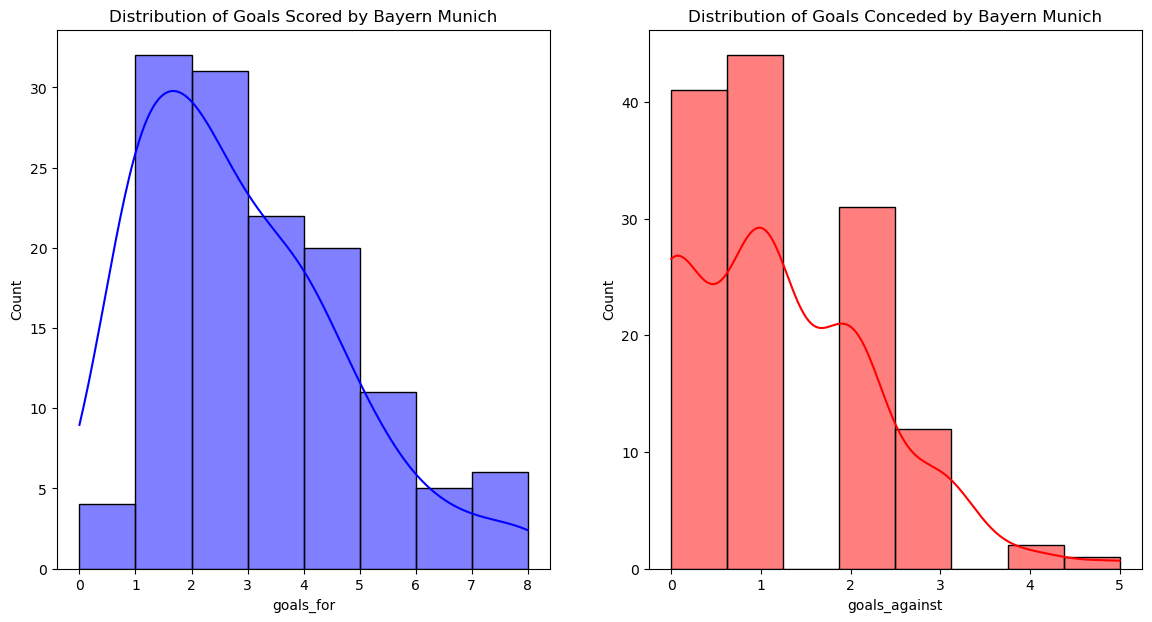

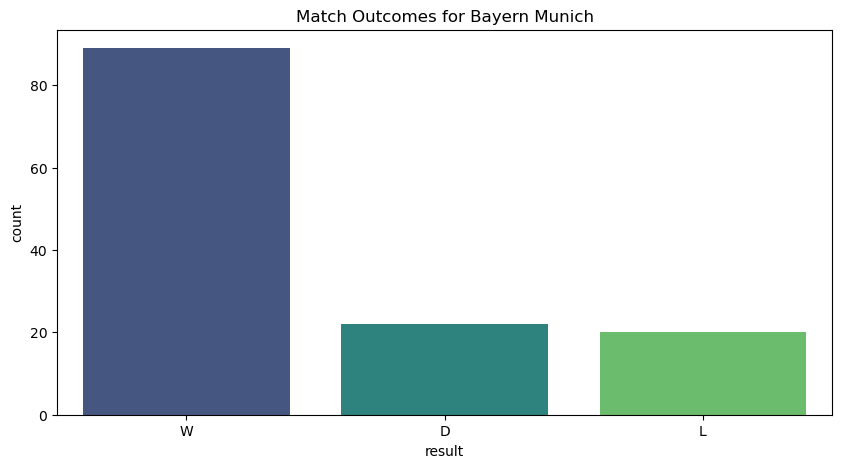

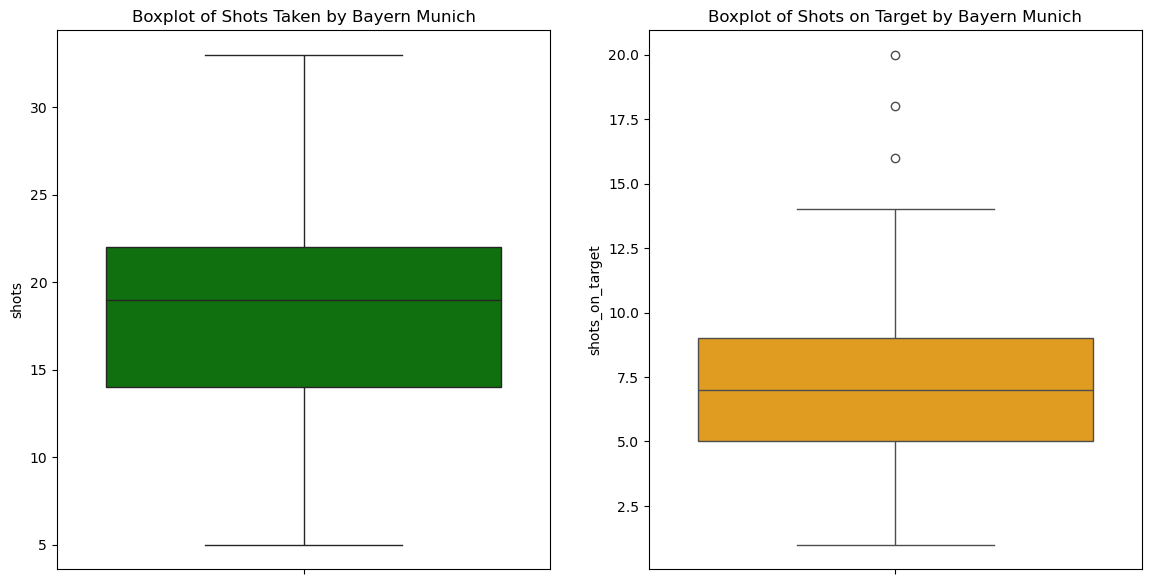

Bayern Munich Numerical Statistics:
                                 date        time       season   goals_for  \
count                            131  131.000000   131.000000  131.000000   
mean   2022-06-14 20:53:07.786259456   16.938931  2022.442748    2.824427   
min              2020-09-18 00:00:00   15.000000  2021.000000    0.000000   
25%              2021-05-18 12:00:00   15.000000  2021.000000    1.000000   
50%              2022-04-30 00:00:00   17.000000  2022.000000    2.000000   
75%              2023-05-03 00:00:00   18.000000  2023.000000    4.000000   
max              2024-04-13 00:00:00   20.000000  2024.000000    8.000000   
std                              NaN    1.948395     1.103563    1.803761   

       goals_against  expected_goals  expected_goals_against       shots  \
count     131.000000      131.000000              131.000000  131.000000   
mean        1.183206        2.419847                1.070992   18.580153   
min         0.000000        0.500000     

In [36]:
# Filter dataset for Bayern Munich
bayern_data = full_matches_dataset[full_matches_dataset['team'] == 'Bayern Munich']

# Summary statistics for numerical columns specific to Bayern Munich
bayern_numerical_stats = bayern_data.describe()

# Visualizations
# Goals For and Against Distribution
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
sns.histplot(bayern_data['goals_for'], bins=8, kde=True, color='blue')
plt.title('Distribution of Goals Scored by Bayern Munich')

plt.subplot(1, 2, 2)
sns.histplot(bayern_data['goals_against'], bins=8, kde=True, color='red')
plt.title('Distribution of Goals Conceded by Bayern Munich')

# Result Distribution
plt.figure(figsize=(10, 5))
sns.countplot(x='result', data=bayern_data, order=['W', 'D', 'L'], palette='viridis')
plt.title('Match Outcomes for Bayern Munich')

# Boxplot for shots and shots on target
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
sns.boxplot(y=bayern_data['shots'], color='green')
plt.title('Boxplot of Shots Taken by Bayern Munich')

plt.subplot(1, 2, 2)
sns.boxplot(y=bayern_data['shots_on_target'], color='orange')
plt.title('Boxplot of Shots on Target by Bayern Munich')

plt.show()

# Output numerical stats
print("Bayern Munich Numerical Statistics:\n", bayern_numerical_stats)

#### 6.1.4 Insights of Bayern Munich

**Distribution of Goals Scored**
- The histogram shows that the most common number of goals scored by Bayern Munich in a match is 1 or 2, with a significant frequency of matches with 3 goals as well.
- There is a tail that extends to 8 goals, indicating that there have been a few matches where Bayern Munich has scored a very high number of goals. This is characteristic of a dominant offensive team.

**Distribution of Goals Conceded**
- The histogram indicates that Bayern Munich most commonly concedes 1 goal in a match, with matches where they concede 0 goals also being quite common.
- The distribution drops significantly for games where they concede more than 2 goals, suggesting that their defense is quite solid, and it is rare for them to concede many goals.

**Match Outcomes**
- The count plot shows a high number of wins (denoted by 'W') compared to draws ('D') and losses ('L'), indicating a very successful period for Bayern Munich.
- This visual evidence supports Bayern Munich's reputation as a top-performing team, likely contending for the title in most seasons.

**Boxplot of Shots Taken**
- The boxplot demonstrates that Bayern Munich consistently takes a high number of shots per match, with the median around 18.
- The range is broad, with some matches featuring an exceptionally high shot count, highlighting Bayern's aggressive playstyle.

**Boxplot of Shots on Target**
- The number of shots on target has a tighter distribution with a lower median than the total shots taken.
- There are a few outliers indicating matches where Bayern Munich had an unusually high number of shots on target.

#### 6.1.5 Numerical Statistics Insights for Bayern Munich

**Time and Season**
- **Game Timing:** Bayern Munich's matches skew slightly later in the day compared to the league average, with a mean time around 17:00. This could be due to prime-time broadcasting slots.
- **Seasonal Data:** The data spans the same four seasons as the overall dataset, ensuring that we have a consistent time frame for analysis.

**Offensive Metrics** 
- **Goals Scored:** On average, Bayern Munich scores about 2.82 goals per match, which is significantly higher than the overall league average of 1.56 goals. This high mean is a testament to their offensive prowess.
- **Expected Goals:** The expected goals metric at 2.42 is also higher than the league average, which indicates that Bayern Munich creates high-quality scoring chances.
- **Shots and Shots on Target:** They take an average of 18.58 shots per match, with about 7.09 on target. These values are considerably higher than the league averages, suggesting Bayern Munich's attacking play is very active and they manage to direct a good proportion of their shots on goal.

**Defensive Metrics**
- **Goals Against:** Bayern Munich concedes 1.18 goals per match on average, which is lower than the league's average of 1.56, reflecting a strong defensive record.
- **Expected Goals Against:** At 1.07, the expected goals against is also lower than the league average, showing that they generally do not give up many high-quality chances.

**Ball Possession and Movement**
- **Possession:** They average nearly 63% possession per match, significantly higher than the league's 50%, suggesting a dominant ball-control style.
- **Distance Covered:** The team covers an average distance of 16.57 km per match, which is slightly lower than the overall league average. This could be indicative of Bayern Munich's style, potentially not needing to cover as much ground due to better control of the play and positioning.

**Environmental and Contextual Factors**
- **Weather:** They play in a variety of weather conditions, with precipitation and snowfall reflecting the league's diverse seasonal conditions. The attendance data shows an average of 35,166, higher than the league average, which is expected for a high-profile team like Bayern Munich.

**Attendance and Audience**
- **No Audience Matches:** About 27% of Bayern Munich's matches are played without an audience, which is slightly higher than the league average of 24.7%. This could be due to strict regulations at their home stadium or particular away games.

From this data, we can conclude that Bayern Munich is an offensively dominant team with a solid defensive foundation. They are likely to be at the top end of the league, both in terms of performance and popularity. The data also suggests they are a marquee team, often playing in prime-time slots with a large fan following. The slightly higher percentage of games without an audience for Bayern Munich might indicate that their games are impacted more by external factors, possibly due to the larger crowd they draw.

### 6.2 Simple Data Visualization

#### 6.2.1 Histogram for goals scored

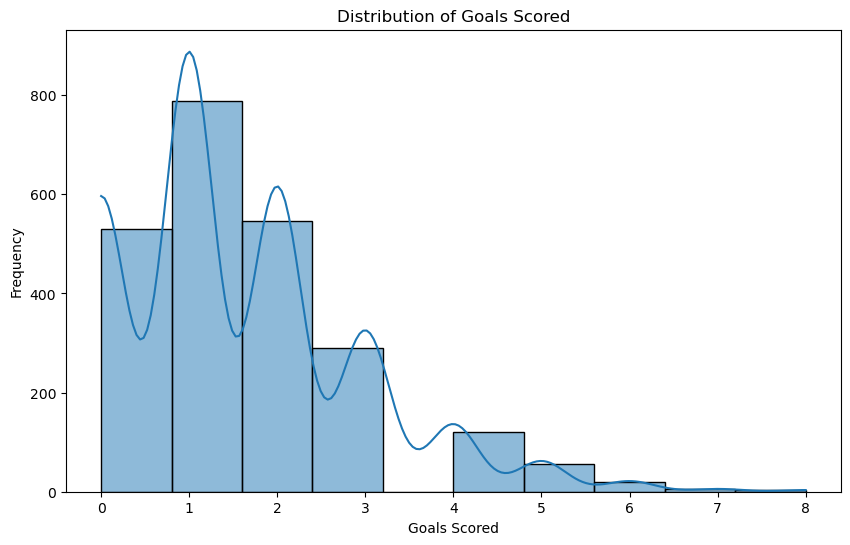

In [37]:
# Histogram for goals scored
plt.figure(figsize=(10, 6))
sns.histplot(data=full_matches_dataset, x='goals_for', bins=10, kde=True)
plt.title('Distribution of Goals Scored')
plt.xlabel('Goals Scored')
plt.ylabel('Frequency')
plt.show()

- This histogram shows the frequency of goals scored per match. The most common number of goals scored by a team in a match is 1, as shown by the highest bar. The frequency decreases as the number of goals increases, which is typical in football matches since high-scoring games are less common.
- There's a long tail to the right, indicating that there are a few matches where a team scores a very high number of goals, but these are outliers.
- The distribution appears to be right-skewed, meaning that scoring more than 2 or 3 goals in a match is less frequent.

#### 6.2.2 Box plot for ball possession

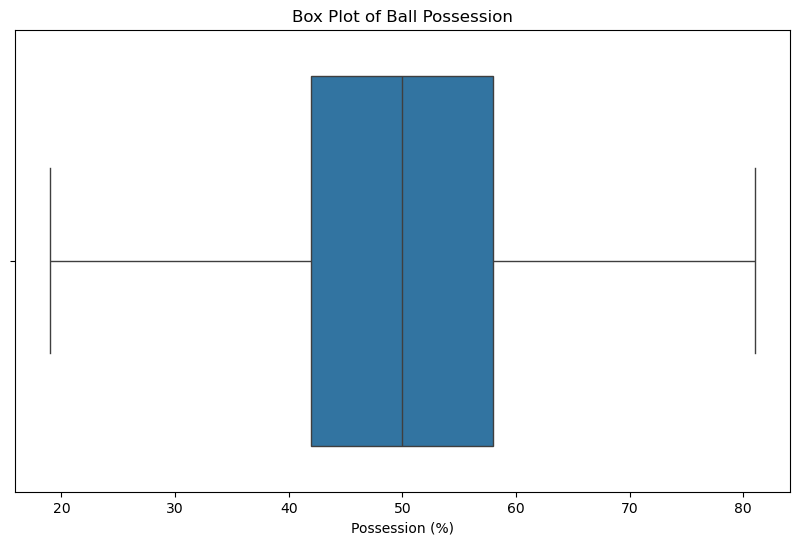

In [38]:
# Box plot for ball possession
plt.figure(figsize=(10, 6))
sns.boxplot(data=full_matches_dataset, x='possession')
plt.title('Box Plot of Ball Possession')
plt.xlabel('Possession (%)')
plt.show()

- The box plot for ball possession shows the median possession percentage is around the 50% mark, which is expected since, on average, teams will share possession equally.
- The interquartile range (the box) is quite narrow, suggesting that most of the data points (i.e., ball possession percentages) are close to the median. This indicates a consistency in possession statistics across matches.
- There are no significant outliers, and the spread is relatively even, suggesting that extreme possession percentages (very low or very high) are rare.

#### 6.2.3 Locations where matches are played

In [39]:
# Create a base map
map = folium.Map(location=[51.1657, 10.4515], zoom_start=6)  # Coordinates roughly centered on Germany

# Add markers for stadiums
for idx, row in full_matches_dataset.drop_duplicates(subset=['stadium']).iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"{row['stadium']} - {row['city']}",
        icon=folium.Icon(icon='soccer-ball-o', prefix='fa')
    ).add_to(map)

map

- The map has markers placed on the locations of Bundesliga stadiums. This geographic distribution can be helpful to understand regional patterns in attendance, team performance, or even how weather might affect matches.
- The map shows that the Bundesliga teams are relatively well distributed across Germany, with a higher concentration of teams in the western part of the country.
- This spatial information could be used to analyze if there are 'strongholds' where certain teams dominate or if performance is influenced by geographic factors.

### 6.3 Comparative Data Analysis

#### 6.3.1 Home vs. Away Performance Analysis

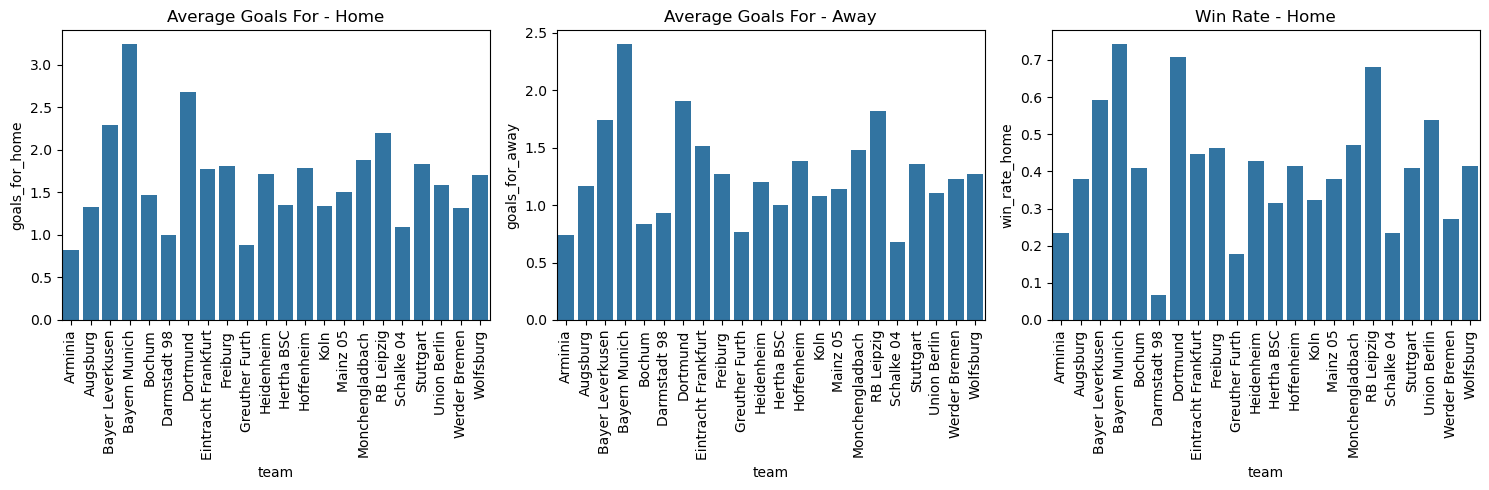

In [40]:
# Calculate home vs away metrics
home_away_metrics = full_matches_dataset.groupby(['team', 'venue']).agg({
    'goals_for': 'mean',
    'possession': 'mean',
    'result': lambda x: (x == 'W').mean()  # Calculate win rate directly
}).unstack()


home_away_metrics.head()
# Rename columns explicitly
home_away_metrics.columns = ['goals_for_away', 'goals_for_home', 'possession_away', 'possession_home', 'win_rate_away', 'win_rate_home']

# Plotting the results
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

sns.barplot(data=home_away_metrics.reset_index(), x='team', y='goals_for_home', ax=axes[0])
axes[0].set_title('Average Goals For - Home')
axes[0].tick_params(axis='x', rotation=90)

sns.barplot(data=home_away_metrics.reset_index(), x='team', y='goals_for_away', ax=axes[1])
axes[1].set_title('Average Goals For - Away')
axes[1].tick_params(axis='x', rotation=90)

sns.barplot(data=home_away_metrics.reset_index(), x='team', y='win_rate_home', ax=axes[2])
axes[2].set_title('Win Rate - Home')
axes[2].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

#### 6.3.2 Head-to-Head Performance

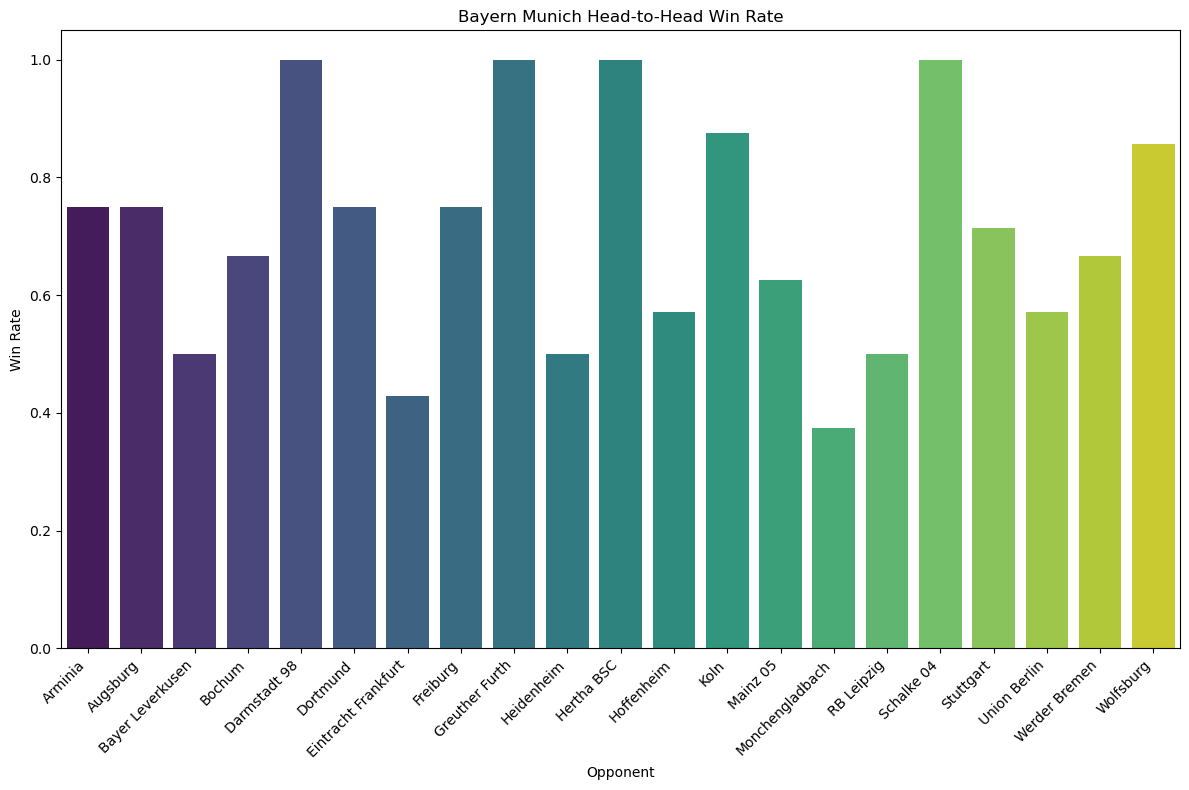

In [41]:
# Aggregating head-to-head results
h2h_results = full_matches_dataset.groupby(['team', 'opponent']).agg({
    'result': lambda x: (x == 'W').mean(),
    'goals_for': 'mean',
    'goals_against': 'mean'
}).reset_index()

# Example plot for Bayern Munich's head-to-head results
bayern_h2h = h2h_results[h2h_results['team'] == 'Bayern Munich']

plt.figure(figsize=(12, 8))  # Adjusted figure size for better fit
barplot = sns.barplot(data=bayern_h2h, x='opponent', y='result', hue='opponent', dodge=False, palette='viridis')
plt.title('Bayern Munich Head-to-Head Win Rate')
plt.xticks(rotation=45, ha='right')  # Adjusted rotation and horizontal alignment
plt.ylabel('Win Rate')
plt.xlabel('Opponent')
plt.tight_layout()  # Adjust layout to fit everything
plt.show()

- **Win Rate Variation:** The win rate against different teams varies significantly, which is evident from the height of the bars. Some opponents seem easier for Bayern Munich to beat than others based on historical data.
- **Toughest Opponents:** The tallest bars represent the teams against which Bayern Munich has the highest win rate. These teams might be considered favorable matchups for Bayern Munich historically.
- **Strongest Performance:** The shorter bars indicate opponents against which Bayern Munich has a lower win rate. These might be teams that historically pose a challenge to Bayern Munich, leading to a lower percentage of wins.
- **Color Gradient:** The gradient color change from dark purple to yellow across the bars does not appear to follow a particular pattern; rather, it's a visual design choice. It does not seem to correlate with the win rate or any other variable.
- **Potential for Further Analysis:** While the chart shows win rates, it does not account for draws or losses. Including additional metrics such as draw rate or loss rate could provide a more comprehensive understanding of the performance.
- **Contextual Factors:** The win rate alone does not provide the full context. Factors such as home vs. away games, seasons, or player availability can significantly impact these results. Further analysis considering these factors could give a better understanding of the performance dynamics.

### 6.4 Advanced Analysis

#### 6.4.1 Impact of Weather on Match Outcomes

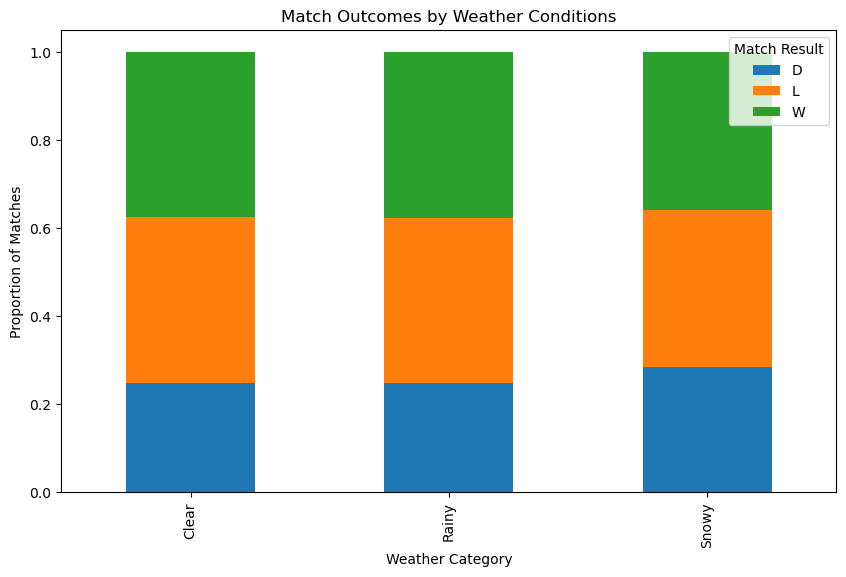

In [42]:
# Group data by weather category and result, and count occurrences
weather_impact = full_matches_dataset.groupby(['weather_category', 'result']).size().unstack()

# Normalize the counts to get proportions
weather_impact = weather_impact.div(weather_impact.sum(axis=1), axis=0)

# Plotting
weather_impact.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Match Outcomes by Weather Conditions')
plt.ylabel('Proportion of Matches')
plt.xlabel('Weather Category')
plt.legend(title='Match Result')
plt.show()

The stacked bar chart shows the proportion of match outcomes (Win, Draw, Loss) under different weather conditions (Clear, Rainy, Snowy). It appears that weather conditions do not significantly alter the proportion of match outcomes. Wins, draws, and losses are distributed relatively evenly across different weather types, suggesting that weather may not have a strong impact on the outcome of a match. However, it's interesting to note that there are slightly more wins in clear conditions compared to rainy and snowy weather.

#### 6.4.2 Referee Influence on Penalties

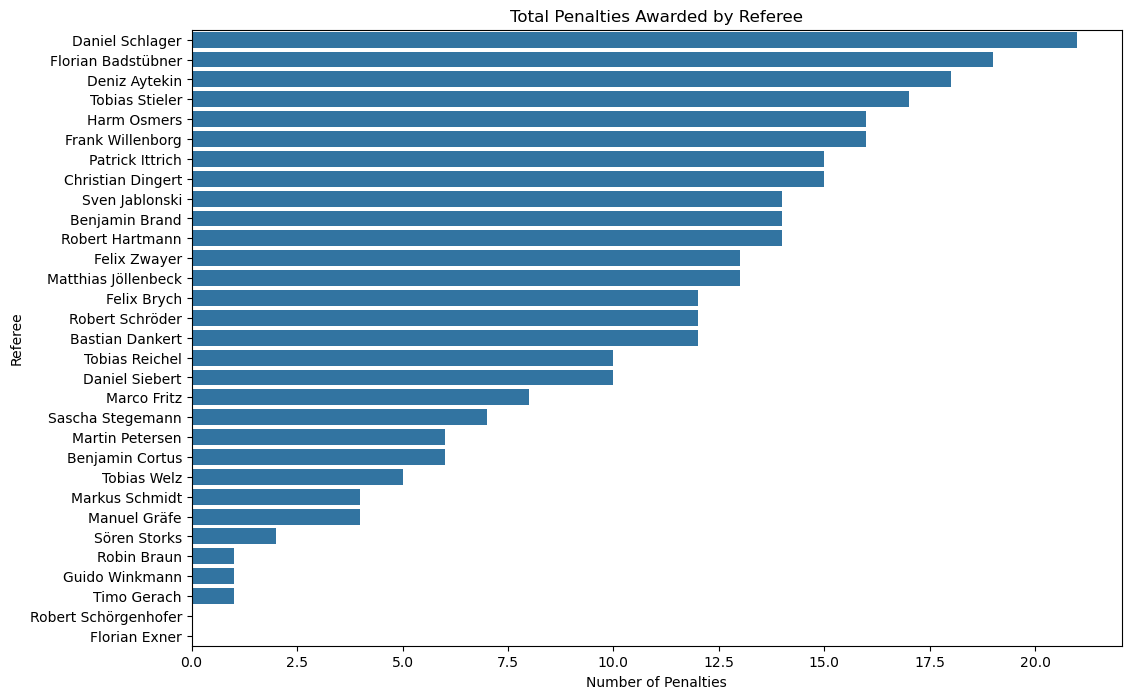

In [43]:
# Group by referee and count penalties
referee_penalties = full_matches_dataset.groupby('referee')['penalties'].sum()

# Sort the data to see top referees associated with penalties
referee_penalties = referee_penalties.sort_values(ascending=False)

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(x=referee_penalties.values, y=referee_penalties.index)
plt.title('Total Penalties Awarded by Referee')
plt.xlabel('Number of Penalties')
plt.ylabel('Referee')
plt.show()

This bar chart displays the number of penalties awarded by different referees. There is a clear variation among referees, with some giving significantly more penalties than others. This could be due to various factors, including the referee's interpretation of the game, the nature of the matches they officiate, or mere chance. Referees at the top of the chart are associated with a higher frequency of penalties, which could warrant further investigation to understand the underlying reasons.

#### 6.4.3 Heatmap of Goals Scored at Different Stadiums

In [44]:
# Create a base map centered around Germany
map = folium.Map(location=[51.1657, 10.4515], zoom_start=6)

# Prepare data for the heatmap
# We need to aggregate goals by latitude and longitude
goal_data = full_matches_dataset.groupby(['latitude', 'longitude']).agg({'goals_for': 'sum'}).reset_index()

# Ensure the columns are floats
goal_data['latitude'] = goal_data['latitude'].astype(float)
goal_data['longitude'] = goal_data['longitude'].astype(float)
goal_data['goals_for'] = goal_data['goals_for'].astype(float)

# Generate a list of coordinates and number of goals scored at those coordinates
heat_data = [[row['latitude'], row['longitude'], row['goals_for']] for index, row in goal_data.iterrows()]

# Create a heat map
HeatMap(heat_data, radius=25, blur=15, max_zoom=1).add_to(map)

# Display the map
map

The heatmap visualizes the concentration of goals scored in the geographical locations of stadiums. Areas with a higher frequency of goals are indicated by warmer colors (red, orange). It shows that certain regions or stadiums are hotspots for goal-scoring. This could be due to factors such as the offensive play style of the home teams, the stadium's atmosphere, or even pitch conditions favoring attacking football. Teams in the areas with the highest intensity might have potent attacks or it could also indicate a trend of high-scoring games in those regions.

#### 6.4.4 Most Common Weather Conditions for each Stadium

In [45]:
# Create a base map centered around Germany
map_germany_weather = folium.Map(location=[51.1657, 10.4515], zoom_start=6)

# Group by stadium and count the most frequent weather_category
stadium_weather = full_matches_dataset.groupby(['stadium', 'latitude', 'longitude'])['weather_category'].agg(lambda x: pd.Series.mode(x).iloc[0]).reset_index()

# Define a color scheme for the weather categories
weather_colors = {
    'Clear': 'green',
    'Rainy': 'blue',
    'Cloudy': 'gray',
    'Snowy': 'white'
}

# Iterate through the grouped DataFrame and add a marker for each stadium
for idx, row in stadium_weather.iterrows():
    # The mode is now assured to be a single value due to lambda function modification
    most_common_weather = row['weather_category']

    # Assign a color based on the most common weather category
    icon_color = weather_colors.get(most_common_weather, 'red')  # Default to red if not found

    # Create a marker with the color and weather information in the popup
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"{row['stadium']}<br>Most Common Weather: {most_common_weather}",
        icon=folium.Icon(color=icon_color, icon='cloud')
    ).add_to(map_germany_weather)
    
map_germany_weather

This map shows markers representing the most common weather condition at each stadium, using a color-coded scheme for different weather types. It appears that most stadiums commonly experience rainy weather, as indicated by the blue markers. A few stadiums, shown with green markers, have clear weather as the most common condition. This distribution could provide insights into regional climatic patterns and how they might affect match planning or team preparations.

#### 6.4.5 Impact of Audience on Team Performance

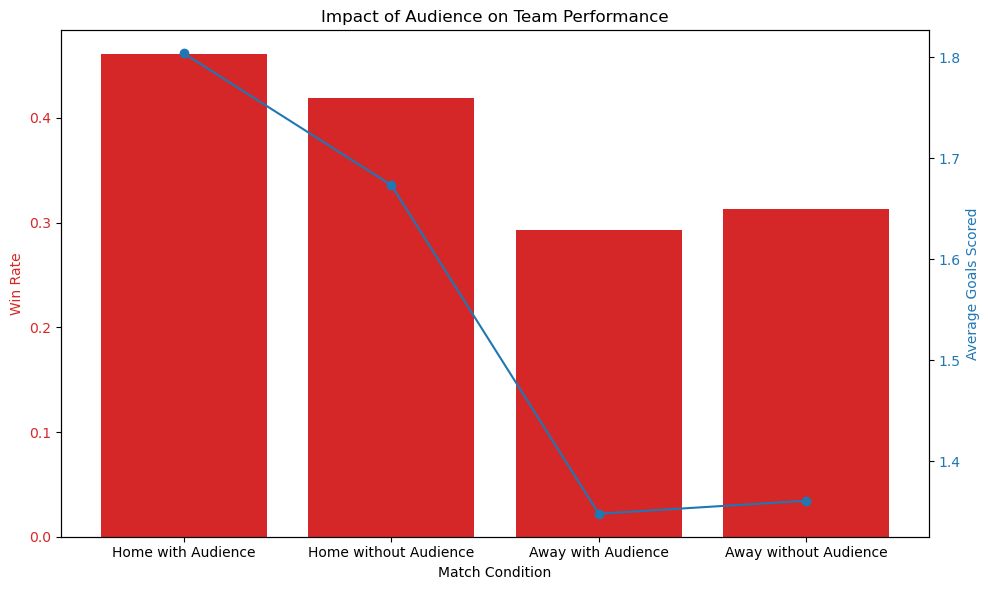

In [46]:
# Calculate win rates and average goals in matches with and without an audience
# Filter out home and away games separately
home_games = full_matches_dataset[full_matches_dataset['venue'] == 'Home']
away_games = full_matches_dataset[full_matches_dataset['venue'] == 'Away']

# Define a function to calculate win rates and average goals
def analyze_performance(data):
    win_rate = data[data['result'] == 'W'].shape[0] / data.shape[0]
    avg_goals_scored = data['goals_for'].mean()
    return win_rate, avg_goals_scored

# Home games with and without audience
home_with_audience = home_games[home_games['no_audience'] == 0]
home_without_audience = home_games[home_games['no_audience'] == 1]

# Away games with and without audience
away_with_audience = away_games[away_games['no_audience'] == 0]
away_without_audience = away_games[away_games['no_audience'] == 1]

# Calculate metrics
home_audience_performance = analyze_performance(home_with_audience)
home_no_audience_performance = analyze_performance(home_without_audience)
away_audience_performance = analyze_performance(away_with_audience)
away_no_audience_performance = analyze_performance(away_without_audience)

# Setting up the data for plotting
categories = ['Home with Audience', 'Home without Audience', 'Away with Audience', 'Away without Audience']
win_rates = [home_audience_performance[0], home_no_audience_performance[0], away_audience_performance[0], away_no_audience_performance[0]]
avg_goals = [home_audience_performance[1], home_no_audience_performance[1], away_audience_performance[1], away_no_audience_performance[1]]

fig, ax1 = plt.subplots(figsize=(10, 6))

# Creating bars for win rates
ax1.set_xlabel('Match Condition')
ax1.set_ylabel('Win Rate', color='tab:red')
ax1.bar(categories, win_rates, color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')

# Instantiate a second axes that shares the same x-axis
ax2 = ax1.twinx()  
ax2.set_ylabel('Average Goals Scored', color='tab:blue')  # we already handled the x-label with ax1
ax2.plot(categories, avg_goals, color='tab:blue', marker='o')
ax2.tick_params(axis='y', labelcolor='tab:blue')

# Final touches
plt.title('Impact of Audience on Team Performance')
fig.tight_layout()  # to ensure no overlap of labels
plt.show()

The combined bar and line graph compares the win rate and average goals scored for home and away matches, with and without an audience. The win rate is higher for home games with an audience, which is a common expectation due to the 'home advantage'. Interestingly, the win rate drops for home games without an audience, indicating that crowd support might play a significant role in boosting team performance. For away games, the win rate is lower compared to home games, and there is a slight increase when there is no audience. Average goals scored don't seem to vary significantly between these conditions. This suggests that while the presence of an audience may influence the likelihood of a win, it does not drastically change the scoring ability of a team.

### 6.5 Trend Analysis

#### 6.5.1 Performance Trends Over Seasons for Home Games

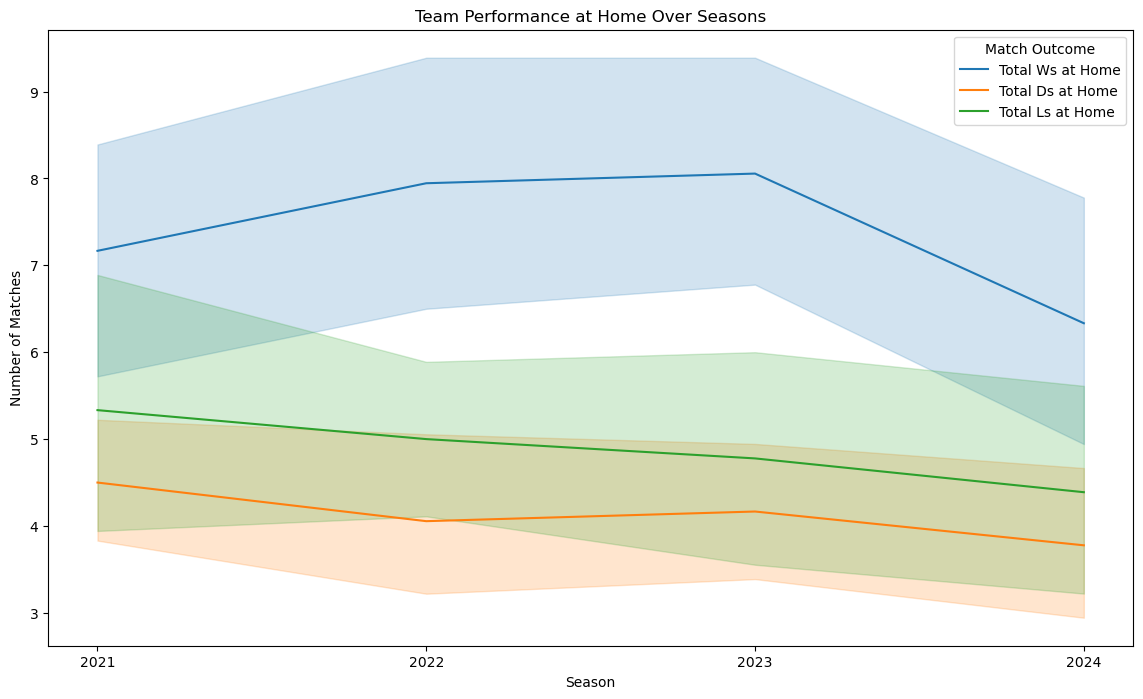

In [47]:
# Make a copy of the dataset
df = full_matches_dataset.copy()

# Convert date to datetime for easier handling
df['date'] = pd.to_datetime(df['date'])

# Filter only home games to avoid double counting
home_games = df[df['venue'] == 'Home']

# Aggregate data for total wins, draws, and losses per team per season for home games only
seasonal_home_performance = home_games.groupby(['season', 'team', 'result']).size().unstack(fill_value=0).reset_index()

# Plotting the trends
fig, ax = plt.subplots(figsize=(14, 8))
for outcome in ['W', 'D', 'L']:
    sns.lineplot(data=seasonal_home_performance, x='season', y=outcome, ax=ax, label=f'Total {outcome}s at Home')
ax.set_title('Team Performance at Home Over Seasons')
ax.set_ylabel('Number of Matches')
ax.set_xlabel('Season')
plt.xticks(seasonal_home_performance['season'].unique())  # Ensure all seasons are displayed
plt.legend(title='Match Outcome')
plt.show()

- **Wins:** There is a noticeable trend where the number of wins at home has generally decreased over the seasons. This might indicate that teams are finding it more challenging to secure victories at home, or the league is becoming more competitive.
- **Draws**: The number of draws at home shows slight fluctuation but no clear trend over time. This suggests that the likelihood of a draw has remained relatively stable.
- **Losses:** There is an increase in the number of losses at home, especially noticeable from the third season to the fourth. This could reflect the same factors contributing to the decrease in wins, such as increased competition or changes in team performance or strategy.

#### 6.5.2 Trend in Goals Scored by Match Week

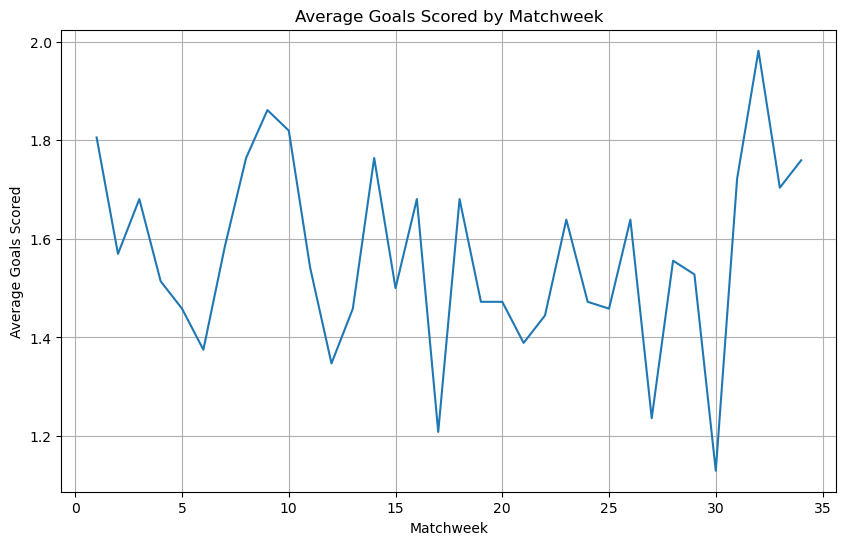

In [48]:
# Make a copy of the dataset
df = full_matches_dataset.copy()

# Convert round to numerical format for easier plotting
df['matchweek'] = df['round'].str.extract('(\d+)').astype(int)

# Calculate average goals scored by matchweek
goals_by_week = df.groupby('matchweek')['goals_for'].mean().reset_index()

# Plotting the trends
plt.figure(figsize=(10, 6))
sns.lineplot(data=goals_by_week, x='matchweek', y='goals_for')
plt.title('Average Goals Scored by Matchweek')
plt.xlabel('Matchweek')
plt.ylabel('Average Goals Scored')
plt.grid(True)
plt.show()

- There is considerable variability in goals scored from week to week, which is to be expected in football matches.
- There's a sharp increase towards the last matchweek, suggesting that the final games of the season might have a higher number of goals. This could be due to several factors, such as lower-ranked teams having less to lose and therefore playing more offensively, or top teams intensifying their efforts to secure titles or qualify for European competitions.

#### 6.5.3 Effect of Time of Day on Match Outcomes For Home Games

C:\Users\Besfort\AppData\Local\Temp\ipykernel_20200\2138500920.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_home_games['result_points'] = df_home_games['result'].map(result_map)
C:\Users\Besfort\AppData\Local\Temp\ipykernel_20200\2138500920.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=time_of_day_performance, x='time_of_day', y='result_points', palette='coolwarm')


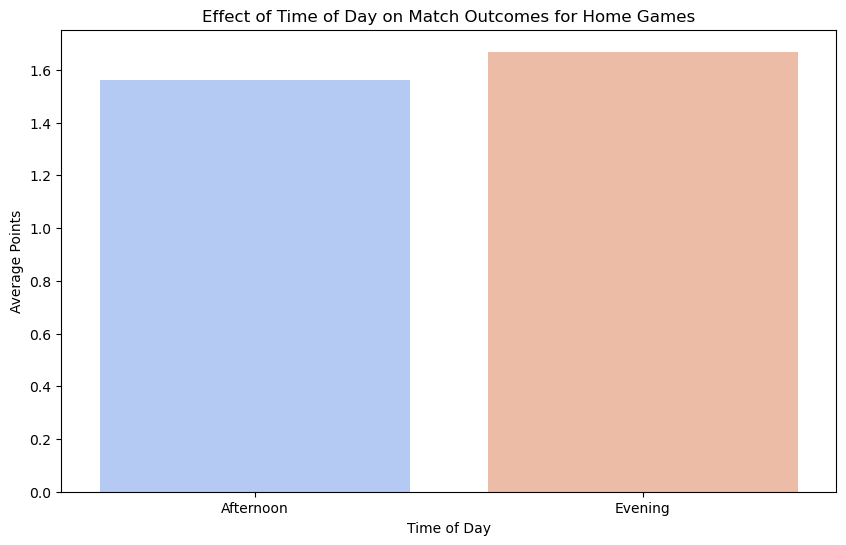

In [49]:
# Make a copy of the dataset
df = full_matches_dataset.copy()

# Filter out the away games to avoid duplicate counting
df_home_games = df[df['venue'] == 'Home']

# Mapping results to correct point values
result_map = {'W': 3, 'D': 1, 'L': 0}
df_home_games['result_points'] = df_home_games['result'].map(result_map)

# Group by time of day and calculate average result points
time_of_day_performance = df_home_games.groupby('time_of_day')['result_points'].mean().reset_index()

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(data=time_of_day_performance, x='time_of_day', y='result_points', palette='coolwarm')
plt.title('Effect of Time of Day on Match Outcomes for Home Games')
plt.xlabel('Time of Day')
plt.ylabel('Average Points')
plt.show()

- **Afternoon games:** The graph indicates that teams earn fewer points from home games that are played in the afternoon. This could be due to a variety of factors, such as player routines and energy levels being better suited to later games, or possibly differences in the way teams approach early kick-offs.
- **Evenening games:** Conversely, teams appear to earn more points from home games played in the evening. The reasons for this could be multifold: players might be more energized and focused during evening matches, the atmosphere created by fans under the lights could be more intense and supportive, or there could be strategic adaptations for evening games that result in better outcomes.

## 7. Feature Engineering

In this chapter, we delve into feature engineering, a critical step in preparing our dataset for effective machine learning. We will create new features that enhance the model's predictive power and transform existing data into formats that are more suitable for analysis. This process includes encoding categorical variables and possibly scaling and normalizing data. Our aim is to develop a dataset that not only captures the essence of the underlying patterns but also optimizes the performance of our predictive models.

In [50]:
dataset_full = full_matches_dataset
dataset_full.head()

,date,time,time_of_day,season,competition,round,match_day,team,opponent,venue,...,rain_sum,snowfall_sum,stadium,city,latitude,longitude,weather_code,attendance,referee,no_audience
id,,,,,,,,,,,,,,,,,,,,,
1,2023-08-19,15,Afternoon,2024,Bundesliga,Matchweek 1,Sat,Bayer Leverkusen,RB Leipzig,Home,...,5.3,0.0,BayArena,Leverkusen,51.0383,7.00221,63,29464,Felix Brych,0
2,2023-08-26,18,Evening,2024,Bundesliga,Matchweek 2,Sat,Bayer Leverkusen,Monchengladbach,Away,...,1.8,0.0,Borussia-Park,Mönchengladbach,51.1746,6.38546,53,54042,Christian Dingert,0
3,2023-09-02,15,Afternoon,2024,Bundesliga,Matchweek 3,Sat,Bayer Leverkusen,Darmstadt 98,Home,...,0.2,0.0,BayArena,Leverkusen,51.0383,7.00221,51,29653,Sven Jablonski,0
4,2023-09-15,20,Evening,2024,Bundesliga,Matchweek 4,Fri,Bayer Leverkusen,Bayern Munich,Away,...,0.0,0.0,Allianz Arena,Munich,48.2188,11.62480,3,75000,Daniel Schlager,0
5,2023-09-24,15,Afternoon,2024,Bundesliga,Matchweek 5,Sun,Bayer Leverkusen,Heidenheim,Home,...,0.0,0.0,BayArena,Leverkusen,51.0383,7.00221,1,29557,Christian Dingert,0


In [51]:
dataset_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2358 entries, 1 to 2358
Data columns (total 36 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    2358 non-null   datetime64[ns]
 1   time                    2358 non-null   int32         
 2   time_of_day             2358 non-null   object        
 3   season                  2358 non-null   int64         
 4   competition             2358 non-null   object        
 5   round                   2358 non-null   object        
 6   match_day               2358 non-null   object        
 7   team                    2358 non-null   object        
 8   opponent                2358 non-null   object        
 9   venue                   2358 non-null   object        
 10  captain                 2358 non-null   object        
 11  formation               2358 non-null   object        
 12  result                  2358 non-null   object       

#### 7.1 Columns to Remove

It's important to focus on the features that are likely to influence the outcome of a match while avoiding redundancy and features that don't add predictive value or could introduce bias. Thus, we remove following columns from our dataset:
- **competition**: Since it contains only "Bundesliga", it provides no variability or predictive value.
- **captain**: While leadership can impact game outcomes, this variable is likely too specific and not quantifiable for useful predictions in this context.
- **stadium, city, latitude, longitude**: These are highly specific and their predictive value is likely captured by the 'venue' (Home/Away) variable. Geographical impact is also minimal within a single country league unless specific stadium effects are proven significant, which typically requires more detailed historical data.
- **weather_code**: Since we already have 'weather_category', 'mean_temperature', 'precipitation_sum', 'rain_sum', and 'snowfall_sum', the weather code might be redundant unless it provides additional, non-duplicated information.
- **attendance**: This is directly derived from 'no_audience'. If 'attendance' is zero, 'no_audience' has the value 1. Otherwise it's 0.
- **time**: Since we already have 'time_of_day' as categorical variable.

In [52]:
dataset_full = dataset_full.drop(columns=['competition', 'captain', 'stadium', 'city', 'latitude', 'longitude', 'weather_code', 'attendance', 'time'])

### 7.2 Aggregate Features

When preparing the model for predicting Bundesliga match outcomes, it's crucial to recognize that certain match-specific statistics cannot be predicted ahead of time but can instead be used to derive more general indicators of team performance over the course of the season. Aggregating these statistics as seasonal averages or rolling averages provides a historical perspective on a team's form and abilities, which can be a powerful predictor for future matches. Here are the specific statistics we consider aggregating:
- **goals_for**: The total goals scored by the team can be averaged to gauge offensive strength.
- **goals_against**: Average goals conceded can indicate the team's defensive weaknesses or strengths.
- **expected_goals**: This provides an insight into the quality of chances created, useful for understanding how well teams convert chances into goals.
- **expected_goals_against**: Reflects the quality of chances conceded, giving an idea of defensive solidity.
- **shots**: Total shots taken can show how offensive and aggressive a team is in general.
- **shots_on_target**: Indicates the accuracy and danger of the team's shots.
- **possession**: Average possession percentage can tell you about the team's style of play and control over matches.
- **free_kicks**: This statistic, while more variable, can give insights into the game's dynamics and possible scoring opportunities from set pieces.
- **penalties**: The number of penalties taken can hint at the attacking pressure a team is able to exert in the box.
- **distance_covered**: This reflects the team's physical effort and can be an indicator of their fitness and intensity.

In [53]:
# Ensure the DataFrame is sorted properly by team and date for consistent rolling calculations
dataset_full.sort_values(by=['team', 'date'], inplace=True)

# Define the columns for which we want to calculate rolling averages
stats_columns = [
    'goals_for', 'goals_against', 'expected_goals', 'expected_goals_against',
    'shots', 'shots_on_target', 'possession', 'free_kicks', 'penalties',
    'distance_covered'
]

# We use window=5 and min_periods=5 to start calculating averages with min. 5 matches
# while using .shift() to avoid including the match's own data in the rolling average
for col in stats_columns:
    dataset_full[f'{col}_rolling_mean'] = dataset_full.groupby('team')[col].transform(
        lambda x: x.rolling(window=5, min_periods=5).mean().shift()
    )

In [54]:
# Remove all the matches that have missing values
dataset_full = dataset_full.dropna()

In [55]:
# Remove all the columns which we calculated the rolling means
dataset_full = dataset_full.drop(stats_columns, axis=1)

In [56]:
dataset_full.head()

,date,time_of_day,season,round,match_day,team,opponent,venue,formation,result,...,goals_for_rolling_mean,goals_against_rolling_mean,expected_goals_rolling_mean,expected_goals_against_rolling_mean,shots_rolling_mean,shots_on_target_rolling_mean,possession_rolling_mean,free_kicks_rolling_mean,penalties_rolling_mean,distance_covered_rolling_mean
id,,,,,,,,,,,,,,,,,,,,,
2228,2020-10-31,Afternoon,2021,Matchweek 6,Sat,Arminia,Dortmund,Home,5-3-2,L,...,0.8,1.6,0.80,1.88,9.6,3.2,46.6,0.4,0.0,22.060000
2229,2020-11-07,Afternoon,2021,Matchweek 7,Sat,Arminia,Union Berlin,Away,4-2-3-1,L,...,0.6,1.8,0.70,1.90,8.2,2.8,44.0,0.4,0.0,21.580000
2230,2020-11-21,Afternoon,2021,Matchweek 8,Sat,Arminia,Bayer Leverkusen,Home,4-1-4-1,L,...,0.4,2.8,0.72,2.02,8.0,2.6,44.4,0.6,0.0,20.340000
2231,2020-11-28,Afternoon,2021,Matchweek 9,Sat,Arminia,RB Leipzig,Away,4-2-3-1,L,...,0.6,3.0,0.50,2.18,6.2,1.8,38.2,0.6,0.0,20.215448
2232,2020-12-05,Afternoon,2021,Matchweek 10,Sat,Arminia,Mainz 05,Home,4-4-2,W,...,0.6,2.6,0.54,2.06,6.8,1.4,39.8,0.4,0.0,19.435448


### 7.3 Encode Categorical Variables

In [57]:
# List of categorical columns to encode
categorical_cols = ['time_of_day', 'season', 'round', 'match_day', 'team', 'opponent', 
                    'venue', 'formation', 'weather_category', 'referee']

# Perform one-hot encoding on categorical columns
# The 'prefix' parameter is optional but can make our resulting columns easier to understand
dataset_full_encoded = pd.get_dummies(dataset_full, columns=categorical_cols, prefix=categorical_cols)

In [58]:
dataset_full_encoded.head()

,date,result,mean_temperature,precipitation_sum,rain_sum,snowfall_sum,no_audience,goals_for_rolling_mean,goals_against_rolling_mean,expected_goals_rolling_mean,...,referee_Robert Schröder,referee_Robert Schörgenhofer,referee_Robin Braun,referee_Sascha Stegemann,referee_Sven Jablonski,referee_Sören Storks,referee_Timo Gerach,referee_Tobias Reichel,referee_Tobias Stieler,referee_Tobias Welz
id,,,,,,,,,,,,,,,,,,,,,
2228,2020-10-31,L,12.81580,1.2,1.2,0.0,1,0.8,1.6,0.80,...,False,False,False,False,False,False,False,False,False,False
2229,2020-11-07,L,7.96400,0.0,0.0,0.0,1,0.6,1.8,0.70,...,False,False,False,False,False,False,False,False,False,False
2230,2020-11-21,L,4.84283,0.8,0.8,0.0,1,0.4,2.8,0.72,...,False,False,False,False,False,False,False,False,False,False
2231,2020-11-28,L,2.30317,0.0,0.0,0.0,1,0.6,3.0,0.50,...,False,False,False,False,False,False,False,False,False,False
2232,2020-12-05,W,3.29075,5.9,5.9,0.0,1,0.6,2.6,0.54,...,False,False,False,False,False,False,False,False,False,False


In [59]:
dataset_full_encoded["no_audience"] = dataset_full_encoded["no_audience"].map({1: True, 0: False})
dataset_full_encoded["no_audience"] = dataset_full_encoded["no_audience"].astype(bool)

## 8. Machine Learning

In this chapter, we will proceed through several key steps to develop and assess a predictive model. We'll start by creating balanced and no-draw samples from our dataset, then split these into training and testing sets. After scaling numerical attributes, we'll train our model and evaluate its performance using key metrics. Finally, we'll interpret these results and make predictions on new data.

### 8.1 Data Sampling

result
W    37.766904
L    37.188612
D    25.044484
Name: proportion, dtype: float64


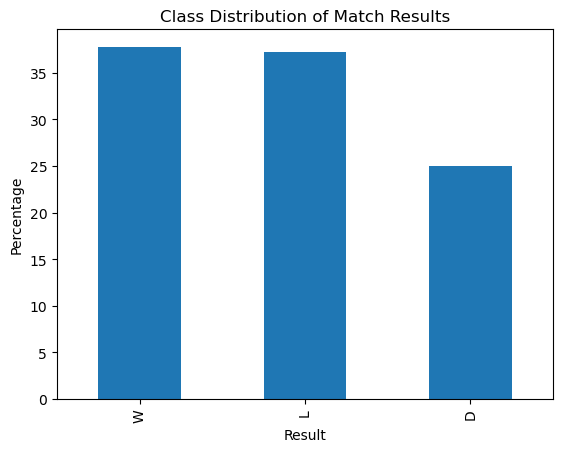

In [60]:
# Calculate the distribution of the target variable 'result'
class_distribution = dataset_full_encoded['result'].value_counts(normalize=True) * 100

# Print the distribution
print(class_distribution)

# Visualize the distribution
import matplotlib.pyplot as plt

class_distribution.plot(kind='bar')
plt.title('Class Distribution of Match Results')
plt.xlabel('Result')
plt.ylabel('Percentage')
plt.show()

Analysis of the bar chart and distribution values reveals some imbalance in the outcomes of match results in our dataset:

- Wins (W): Approximately 37.77%
- Losses (L): Approximately 37.19%
- Draws (D): Approximately 25.04%

While the distribution isn't extremely skewed (it's typical for Wins and Losses to outnumber Draws in football matches), Draws are noticeably underrepresented. This underrepresentation could bias a predictive model, potentially reducing its accuracy when predicting Draws due to fewer examples for training. To address this and assess the impact on model performance, we will construct three distinct data samples:

- **Imbalanced Dataset:** This sample retains all original data, reflecting the natural occurrence of results.
- **Balanced Dataset:** We will adjust the dataset so that the number of 'W' and 'L' matches equals the number of 'D' matches, ensuring equal representation across all classes.
- **No Draws Dataset:** This sample removes all 'D' results, enabling us to focus on a binary classification between 'W' and 'L'."

In [61]:
# Count the number of rows for each result
class_distribution = dataset_full_encoded['result'].value_counts()
print(class_distribution)

result
W    849
L    836
D    563
Name: count, dtype: int64


In [62]:
# Determine the number of rows for the least represented class ('D')
min_class_size = class_distribution['D']
print("Minimum class size for balancing:", min_class_size)

Minimum class size for balancing: 563


In [63]:
# Sample min_class_size rows for each result type
balanced_dataset = pd.concat([
    dataset_full_encoded[dataset_full_encoded['result'] == 'W'].sample(n=min_class_size, random_state=42),
    dataset_full_encoded[dataset_full_encoded['result'] == 'L'].sample(n=min_class_size, random_state=42),
    dataset_full_encoded[dataset_full_encoded['result'] == 'D']
])

In [64]:
# Shuffle the dataset to mix the rows up (optional)
balanced_dataset = balanced_dataset.sample(frac=1, random_state=42).reset_index(drop=True)

In [65]:
no_draws_dataset = dataset_full_encoded[dataset_full_encoded['result'] != 'D']

In [66]:
# Print out the shape of the datasets
print("Shape of the imbalanced dataset:", dataset_full_encoded.shape)
print("Shape of the balanced dataset:", balanced_dataset.shape)
print("Shape of the no draws dataset:", no_draws_dataset.shape)

Shape of the imbalanced dataset: (2248, 164)
Shape of the balanced dataset: (1689, 164)
Shape of the no draws dataset: (1685, 164)


### 8.2 Data Splitting into Train/Test

In [67]:
# Drop 'date' as it is non-predictive or inappropriate and 'result' for separation, it will be used as the target
columns_to_drop = ['date', 'result']

In [68]:
# Prepare the features (X) and target (y) for the imbalanced dataset
X_imbalanced = dataset_full_encoded.drop(columns_to_drop, axis=1)
y_imbalanced = dataset_full_encoded['result']

In [69]:
# Prepare the features (X) and target (y) for the balanced dataset
X_balanced = balanced_dataset.drop(columns_to_drop, axis=1)
y_balanced = balanced_dataset['result']

In [70]:
# Prepare the features (X) and target (y) for the dataset without draws
X_no_draws = no_draws_dataset.drop(columns_to_drop, axis=1)
y_no_draws = no_draws_dataset['result']

In [71]:
# Split the original imbalanced dataset
X_train_imbalanced, X_test_imbalanced, y_train_imbalanced, y_test_imbalanced = train_test_split(
    X_imbalanced, y_imbalanced, test_size=0.2, random_state=9991)

In [72]:
# Split the balanced dataset
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(
    X_balanced, y_balanced, test_size=0.2, random_state=9991)

In [73]:
# Split the dataset without draws
X_train_no_draws, X_test_no_draws, y_train_no_draws, y_test_no_draws = train_test_split(
    X_no_draws, y_no_draws, test_size=0.2, random_state=9991)

### 8.3 Feature Scaling

In [74]:
# Scale imbalance training dataset with StandardScaler
scaler_imbalanced = StandardScaler()

numerical_columns = [
    'goals_for_rolling_mean',
    'goals_against_rolling_mean',
    'expected_goals_rolling_mean',
    'expected_goals_against_rolling_mean',
    'shots_rolling_mean',
    'shots_on_target_rolling_mean',
    'possession_rolling_mean',
    'free_kicks_rolling_mean',
    'penalties_rolling_mean',
    'distance_covered_rolling_mean',
    'mean_temperature',
    'precipitation_sum',
    'rain_sum',
    'snowfall_sum'
]

X_train_imbalanced[numerical_columns] = scaler_imbalanced.fit_transform(X_train_imbalanced[numerical_columns])

In [75]:
# Scale balanced training dataset with StandardScaler
scaler_balanced = StandardScaler()

numerical_columns = [
    'goals_for_rolling_mean',
    'goals_against_rolling_mean',
    'expected_goals_rolling_mean',
    'expected_goals_against_rolling_mean',
    'shots_rolling_mean',
    'shots_on_target_rolling_mean',
    'possession_rolling_mean',
    'free_kicks_rolling_mean',
    'penalties_rolling_mean',
    'distance_covered_rolling_mean',
    'mean_temperature',
    'precipitation_sum',
    'rain_sum',
    'snowfall_sum'
]

X_train_balanced[numerical_columns] = scaler_balanced.fit_transform(X_train_balanced[numerical_columns])

In [76]:
# Scale dataset without draws with StandardScaler
scaler_no_draws = StandardScaler()

numerical_columns = [
    'goals_for_rolling_mean',
    'goals_against_rolling_mean',
    'expected_goals_rolling_mean',
    'expected_goals_against_rolling_mean',
    'shots_rolling_mean',
    'shots_on_target_rolling_mean',
    'possession_rolling_mean',
    'free_kicks_rolling_mean',
    'penalties_rolling_mean',
    'distance_covered_rolling_mean',
    'mean_temperature',
    'precipitation_sum',
    'rain_sum',
    'snowfall_sum'
]

X_train_no_draws[numerical_columns] = scaler_no_draws.fit_transform(X_train_no_draws[numerical_columns])

In [77]:
print("Training and Testing set sizes for each dataset:")
print("Imbalanced - Train: {}, Test: {}".format(X_train_imbalanced.shape, X_test_imbalanced.shape))
print("Balanced - Train: {}, Test: {}".format(X_train_balanced.shape, X_test_balanced.shape))
print("No Draws - Train: {}, Test: {}".format(X_train_no_draws.shape, X_test_no_draws.shape))

Training and Testing set sizes for each dataset:
Imbalanced - Train: (1798, 162), Test: (450, 162)
Balanced - Train: (1351, 162), Test: (338, 162)
No Draws - Train: (1348, 162), Test: (337, 162)


### 8.4 Model Training

Now we want to create the classification model. We decide to use a Random Forest Classifier for several reasons. Random Forest is an ensemble learning method that operates by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes of the individual trees. This model is particularly well-suited for our dataset for the following reasons:
- **Handling Imbalanced Data**: Random Forest can handle imbalances naturally because the ensemble model reduces variance without increasing bias. Each tree in the forest considers only a subset of features and data points, allowing it to capture diverse patterns in the data. This characteristic makes it more robust to noise and variance in class distribution.
- **Feature Importance**: Random Forest provides a straightforward indication of feature importance. Given our dataset with a diverse range of features from one-hot encoded categories to rolling averages of match statistics, understanding which features are most influential in predicting outcomes can provide valuable insights.
- **Non-linear Relationships**: Unlike logistic regression, Random Forest does not assume any linearity in the data. It can model complex interactions between features effectively, which is suitable for sports outcomes where interactions can be non-intuitive or complex.
- **Overfitting Control**: While decision trees tend to overfit, the ensemble nature of Random Forest, which averages multiple trees, generally results in a model that generalizes better to unseen data.
- **Flexibility and Ease of Use**: Random Forest requires very little tuning for decent initial performance. While more sophisticated models might offer slightly higher performance, Random Forest tends to work well with a default set of parameters which makes it a great starting point.

In [78]:
# Create the Random Forest Classifier
rf_classifier_imbalanced = RandomForestClassifier(n_estimators=100, random_state=9991)
rf_classifier_balanced = RandomForestClassifier(n_estimators=100, random_state=9991)
rf_classifier_no_draws = RandomForestClassifier(n_estimators=100, random_state=9991)

In [79]:
# Train the model using the imbalanced dataset
rf_classifier_imbalanced.fit(X_train_imbalanced, y_train_imbalanced)

RandomForestClassifier(random_state=9991)

In [80]:
# Train the model using the balanced dataset
rf_classifier_balanced.fit(X_train_balanced, y_train_balanced)

RandomForestClassifier(random_state=9991)

In [81]:
# Train the model using the dataset without draws
rf_classifier_no_draws.fit(X_train_no_draws, y_train_no_draws)

RandomForestClassifier(random_state=9991)

In [82]:
X_test_imbalanced[numerical_columns] = scaler_imbalanced.transform(X_test_imbalanced[numerical_columns])

# Predict on the test set for imbalanced data
y_pred_imbalanced = rf_classifier_imbalanced.predict(X_test_imbalanced)

In [83]:
X_test_balanced[numerical_columns] = scaler_balanced.transform(X_test_balanced[numerical_columns])

# Predict on the test set for balanced data
y_pred_balanced = rf_classifier_balanced.predict(X_test_balanced)

In [84]:
X_test_no_draws[numerical_columns] = scaler_no_draws.transform(X_test_no_draws[numerical_columns])

# Predict on the test set for no draws data
y_pred_no_draws = rf_classifier_no_draws.predict(X_test_no_draws)

### 8.5 Model Evaluation

In [85]:
print("Imbalanced Dataset:")
print("Accuracy:", accuracy_score(y_test_imbalanced, y_pred_imbalanced))

report = classification_report(y_test_imbalanced, y_pred_imbalanced, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print(report_df)

Imbalanced Dataset:
Accuracy: 0.4666666666666667
              precision    recall  f1-score     support
D              0.363636  0.066116  0.111888  121.000000
L              0.468599  0.563953  0.511873  172.000000
W              0.475113  0.668790  0.555556  157.000000
accuracy       0.466667  0.466667  0.466667    0.466667
macro avg      0.435783  0.432953  0.393106  450.000000
weighted avg   0.442648  0.466667  0.419562  450.000000


In [86]:
print("Balanced Dataset:")
print("Accuracy:", accuracy_score(y_test_balanced, y_pred_balanced))

report = classification_report(y_test_balanced, y_pred_balanced, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print(report_df)

Balanced Dataset:
Accuracy: 0.47633136094674555
              precision    recall  f1-score     support
D              0.434783  0.350877  0.388350  114.000000
L              0.551181  0.560000  0.555556  125.000000
W              0.428571  0.515152  0.467890   99.000000
accuracy       0.476331  0.476331  0.476331    0.476331
macro avg      0.471512  0.475343  0.470598  338.000000
weighted avg   0.476010  0.476331  0.473483  338.000000


In [87]:
print("No Draws Dataset:")
print("Accuracy:", accuracy_score(y_test_no_draws, y_pred_no_draws))

report = classification_report(y_test_no_draws, y_pred_no_draws, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print(report_df)

No Draws Dataset:
Accuracy: 0.6379821958456974
              precision    recall  f1-score     support
L              0.624242  0.631902  0.628049  163.000000
W              0.651163  0.643678  0.647399  174.000000
accuracy       0.637982  0.637982  0.637982    0.637982
macro avg      0.637703  0.637790  0.637724  337.000000
weighted avg   0.638142  0.637982  0.638040  337.000000


### 8.6 Interpreting Metrics

Before interpreting the outcomes from each dataset, let's first define the key metrics used in evaluating classification models:

1. **Accuracy:** The ratio of correctly predicted observations to the total observations. It provides an overall measure of how often the model is correct.
2. **Precision:** The ratio of correctly predicted positive observations to the total predicted positives. It answers the question, "Of all the labels the model predicted to be positive, how many are actually positive?"
3. **Recall (Sensitivity):** The ratio of correctly predicted positive observations to all observations in the actual class. It answers, "Of all the actual positives, how many did the model correctly predict as positive?"
4. **F1-Score:** The weighted average of Precision and Recall. This score takes both false positives and false negatives into account. It is a good way to show that a class has a good balance between Precision and Recall.

#### 8.6.1 Imbalanced Dataset

- **Accuracy (46.67%):** This is slightly above a random guess (which would be 33% for three equally likely outcomes). This indicates that the classifier is correct less than half of the time across all classes, suggesting that the model struggles with making accurate predictions.
- **Precision:** The model has moderate precision for **'L' (46.86%)** and **'W' (47.51%)**, but very low precision for **'D' (36.36%)**. This suggests that when the model predicts a draw, it's often incorrect.
- **Recall:** Recall is highest for **'W' (66.88%)**, indicating the model is relatively better at identifying wins. However, it's particularly poor at identifying **draws (6.61%)**, meaning most actual draws are missed by the model.
- **F1-Score:** The F1-scores are relatively low across all classes, with the highest being **55.56% for wins**, indicating that the model does not balance precision and recall well, especially for draws.

#### 8.6.2 Balanced Dataset

- **Accuracy (47.63%):** This dataset shows a slightly better accuracy than the imbalanced set, but still under 50%, indicating challenges in making correct predictions across the board.
- **Precision:** The precision is more balanced across classes, with the highest for **'L' (55.12%)**. This indicates a moderate improvement in predicting losses accurately when the classes are balanced.
- **Recall:** The recall rates are more evenly distributed, with **'W'** achieving the highest at **51.52%**. This suggests the model has improved in recognizing each class due to balancing.
- **F1-Score:** The F1-scores are closer together but still reflect moderate performance. The balanced training set seems to have helped in evening out the recall and precision to some extent.

#### 8.6.3 No Draws Dataset

- **Accuracy (63.80%):** This is significantly higher than in the datasets that included draws. This suggests that removing the draw class, which might be more ambiguous or harder to predict, allows the model to perform better on the remaining classes. By removing 'Draws', the model could focus on distinguishing between 'Wins' and 'Losses', which might be more straightforward due to clearer differences in their features (e.g., goals scored, possession). However, this approach also reduces the model’s utility by narrowing its applicative scope—i.e., it can no longer predict draws.
- **Precision:** The precision is fairly balanced between **'L'** and **'W'**, both above 62%, which is better compared to the other datasets.
- **Recall:** The recall rates are similar to the precision rates, indicating that the model is relatively effective at identifying wins and losses when draws are not a factor.
- **F1-Score:** The F1-scores are close to 65% for both classes, which are the highest across all datasets. This indicates a good balance between recall and precision when the model does not have to predict draws.

#### **Conclusion**

- The model performs better when the dataset does not include draws, possibly due to the reduced complexity of the classification task.
- Balancing the dataset slightly improves the model's performance, particularly in terms of equity across metrics like precision, recall, and F1-score.
- The imbalanced dataset presents significant challenges, particularly in predicting draws accurately, as evidenced by low recall and F1-scores for the 'D' class.

### 8.7 Confusion Matrix

In [88]:
def plot_confusion_matrix(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    cm_df = pd.DataFrame(cm, index=classes, columns=classes)  # Create a DataFrame for easy plotting
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt="d", cmap='Blues', cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.show()

In [89]:
class_names = ["W", "L", "D"]

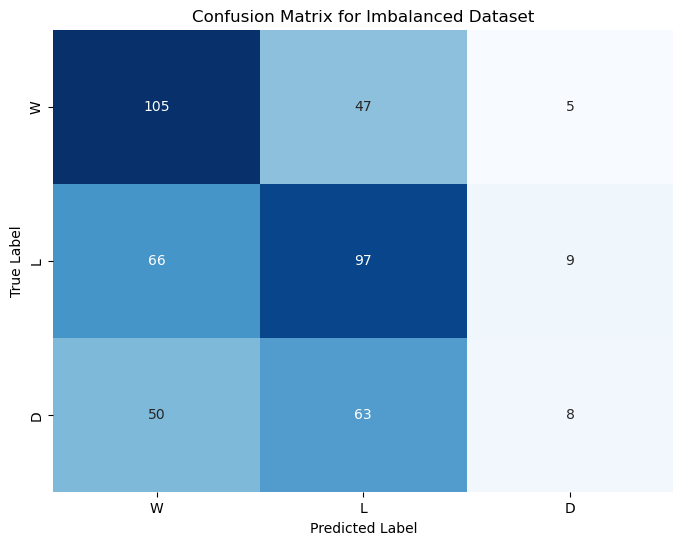

In [90]:
# Plot confusion matrix for the imbalanced dataset
plot_confusion_matrix(y_test_imbalanced, y_pred_imbalanced, class_names, title='Confusion Matrix for Imbalanced Dataset')

The model demonstrates a preference for predicting Wins and Losses over Draws, which is expected given the imbalance in the dataset. There is a significant number of Losses and Draws being incorrectly predicted as Wins. This suggests that features that are strong indicators of Wins may not be as exclusive as needed to differentiate between the other outcomes. The model seems to be challenged by Draws, often confusing them with Wins, which could indicate that characteristics of Draw matches are not distinctly captured by the model or are too similar to those of Win matches in the training data. **Important:** If the classes are not equally represented, the accuracy score is not sufficient to interpret!

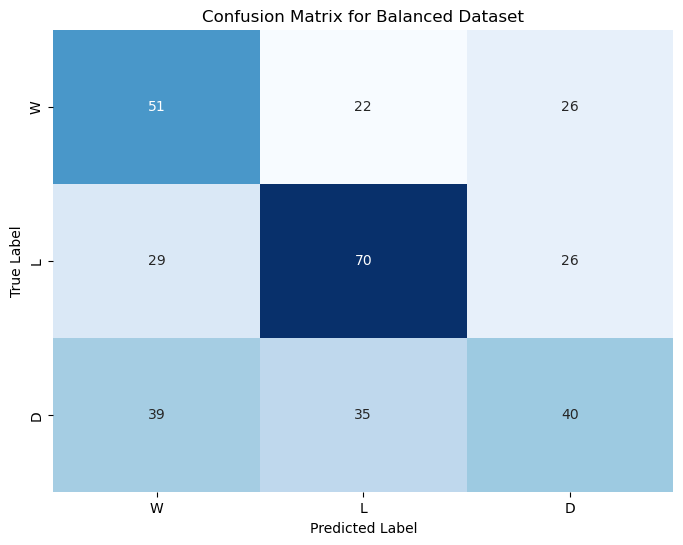

In [91]:
# Plot confusion matrix for the balanced dataset
plot_confusion_matrix(y_test_balanced, y_pred_balanced, class_names, title='Confusion Matrix for Balanced Dataset')

The balanced dataset shows a more uniform distribution of correct predictions across all classes, but the model still struggles with Draws, misclassifying them as Wins or Losses almost equally. This could imply that while the model has now been exposed to more examples of Draws, distinguishing features for Draws are still not being captured effectively. The similar number of misclassifications between Wins as Losses and vice versa indicates the model does not have a strong bias towards a particular outcome, which is an improvement over the imbalanced dataset.

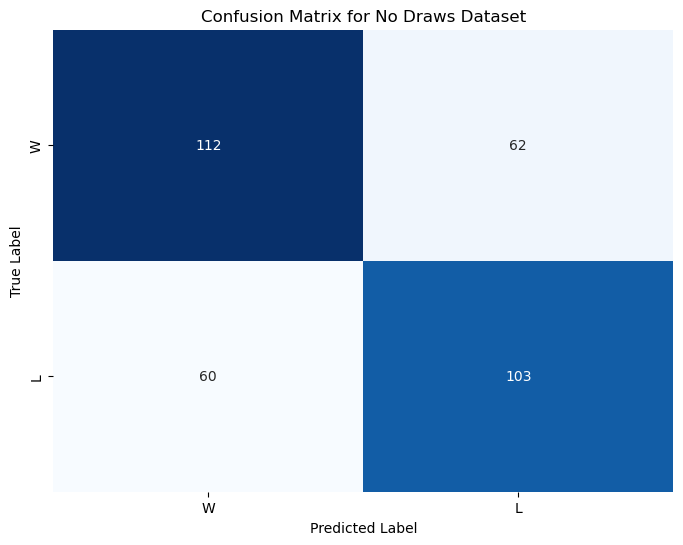

In [92]:
# Plot confusion matrix for the dataset without draws
plot_confusion_matrix(y_test_no_draws, y_pred_no_draws, class_names[:-1], title='Confusion Matrix for No Draws Dataset')

Excluding Draws results in the model's highest performance, indicating a clearer distinction between the features of Wins and Losses. However, there is still a notable number of each being confused for the other. The model's higher accuracy here suggests that when the ambiguity of Draws is removed, the remaining classes are more easily separated, possibly due to more definitive features or less overlap in the feature space between Wins and Losses.

### 8.8 Hyperparameter Tuning

Given that the model without draws demonstrates the highest accuracy among the ones we've considered, it is a strong candidate for further optimization. Therefore, we'll proceed with hyperparameter tuning on this model. Hyperparameter tuning involves adjusting the parameters of the Random Forest algorithm to find the combination that produces the best predictive performance. We could use methods such as grid search or random search to systematically experiment with different hyperparameter values. Through this process, we aim to enhance the model's ability to generalize to new data, further improving its predictive power on unseen matches.

In [93]:
# Define a parameter grid to search over
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 10, 15, 20, 25, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10, 15],  # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4, 5],    # Minimum number of samples required at each leaf node
    'bootstrap': [True, False]        # Method of selecting samples for training each tree
}

In [94]:
# Create a base model to tune
rf_base = RandomForestClassifier(random_state=42)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf_base, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train_no_draws, y_train_no_draws)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 10, 15, 20, 25, 30],
                         'min_samples_leaf': [1, 2, 4, 5],
                         'min_samples_split': [2, 5, 10, 15],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy', verbose=2)

In [95]:
# Print the best parameters
print("Best parameters found: ", grid_search.best_params_)

Best parameters found:  {'bootstrap': False, 'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}


In [96]:
# Use the best parameters to create a new Random Forest model
rf_optimized = grid_search.best_estimator_

In [97]:
# Make predictions using the optimized model
y_pred_optimized = rf_optimized.predict(X_test_no_draws)

In [98]:
# Evaluate the optimized model
print("Accuracy of the optimized model:", accuracy_score(y_test_no_draws, y_pred_optimized))

Accuracy of the optimized model: 0.6409495548961425


The improved accuracy score, now at approximately 64.09% for the optimized Random Forest model, suggests that the hyperparameter tuning process has provided some benefit. Even a slight increase in accuracy can be significant in predictive modeling, particularly in complex tasks such as sports outcome predictions where many factors can influence the result. The optimized model has likely found a better balance between bias and variance, adapting more effectively to the patterns within our dataset.

### 8.9 ROC Curve

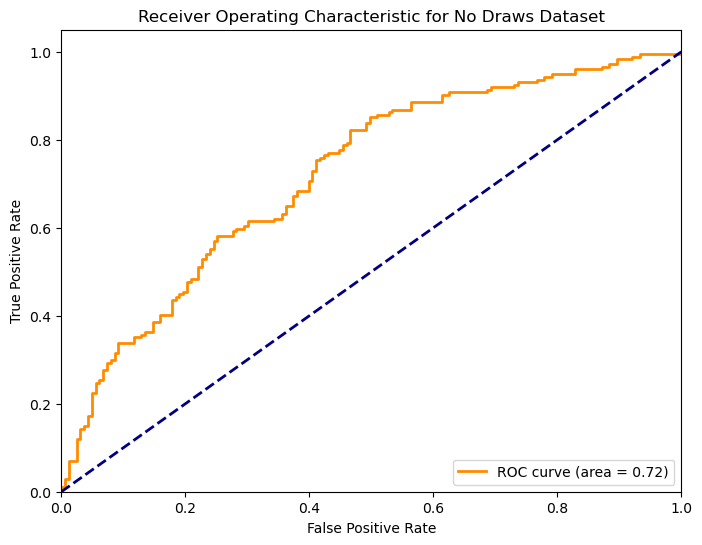

In [99]:
# Compute probabilities for the positive class (Win or Lose)
y_probs_optimized = rf_optimized.predict_proba(X_test_no_draws)[:, 1]  # Change [:,1] depending on how your classes are ordered

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test_no_draws.map({'W': 1, 'L': 0}), y_probs_optimized)  # Ensure mapping is correct for binary case
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for No Draws Dataset')
plt.legend(loc="lower right")
plt.show()

- **Area Under Curve (AUC) of 0.72**: This value indicates a good predictive ability. An AUC of 0.5 would suggest no discriminative ability (equivalent to random guessing), while an AUC of 1.0 represents perfect classification.
- **Curve Shape**: The ROC curve is above the diagonal line of no-discrimination (the dashed blue line), which indicates that the classifier is performing better than random guessing. The curve approaches the top left corner, which implies higher true positive rates for lower false positive rates, a desirable trait in a predictive model.
- **True Positive Rate (TPR)**: Also known as recall or sensitivity, this indicates the proportion of actual positive cases that were correctly identified. The closer the curve follows the left-hand border and then the top border of the ROC space, the more accurate the test.
- **False Positive Rate (FPR)**: This shows the proportion of actual negative cases that were incorrectly classified as positive. The goal is to minimize this rate, which is achieved by the curve staying towards the bottom of the plot as the TPR increases.

### 8.10 Get Feature Importances

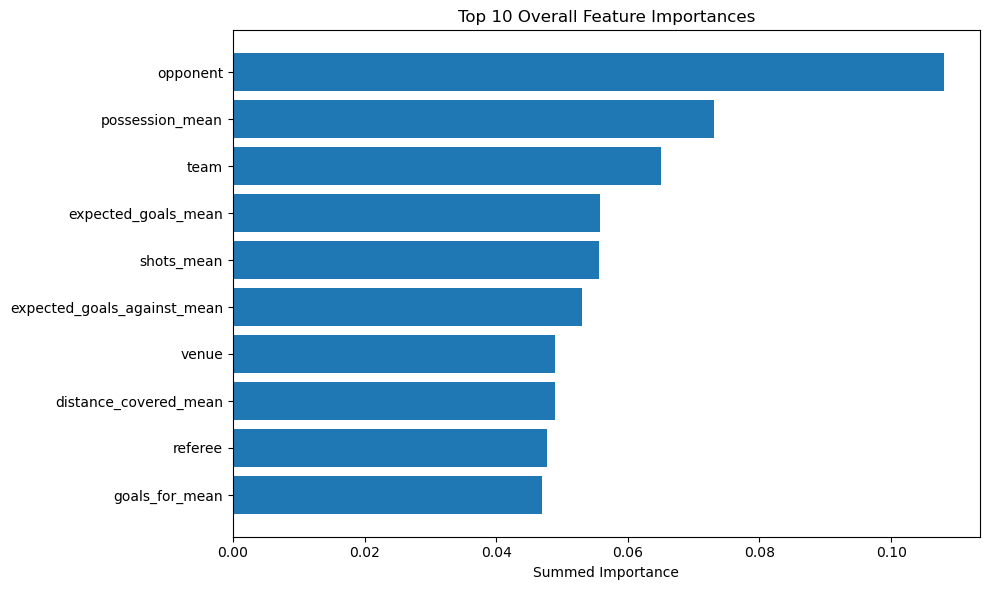

In [100]:
feature_importances = rf_optimized.feature_importances_

# Initialize dictionary to hold the summed importance of the original features
total_importances = {}

# Loop over each feature importance and add it to the corresponding original feature
for col, importance in zip(X_train_no_draws.columns, feature_importances):
    # Determine the original feature's name based on the presence of specific substrings
    if '_rolling_' in col:
        original_feature = col.replace('_rolling_', '_')
    elif '_' in col:  # Handle one-hot encoded categorical features
        original_feature = col.rsplit('_', 1)[0]
    else:
        original_feature = col
    
    # Sum the importances
    total_importances[original_feature] = total_importances.get(original_feature, 0) + importance

# Sort the features by their total importance
sorted_total_importances = sorted(total_importances.items(), key=lambda x: x[1], reverse=True)

# Select the top 10 most important features
top_n = min(10, len(sorted_total_importances))  # Adjust in case there are fewer than 10 features
top_features = sorted_total_importances[:top_n]
top_names = [feature[0] for feature in top_features]
top_scores = [feature[1] for feature in top_features]

# Create a horizontal bar chart for the top 10 features
plt.figure(figsize=(10, 6))
plt.barh(range(top_n), top_scores[::-1], align='center')  # Bars are plotted top to bottom
plt.yticks(range(top_n), top_names[::-1])  # Labels are ordered from top to bottom
plt.xlabel('Summed Importance')
plt.title('Top 10 Overall Feature Importances')
plt.tight_layout()  # Adjust the plot to ensure everything fits without overlapping
plt.show()

1. **Opponent**: The most influential factor is the 'Opponent' team, suggesting that the strength or style of the opposing team is highly indicative of the match outcome. This makes sense as some teams may have historical dominance over others, or particular playing styles that clash.
2. **Possession Mean:** Ball possession is a critical aspect of football, with higher possession often indicating control over the game. Teams that maintain possession are typically able to dictate the pace and create more scoring opportunities.
3. **Team:** Similar to 'Opponent', the importance of 'Team' indicates that the specific characteristics and abilities of the team itself are crucial for the game's outcome. This includes factors like team form, strategy, and player quality.
4. **Expected Goals Mean (xG):** This metric estimates the number of goals a team should have scored based on the quality of their chances. A higher xG suggests more and better scoring opportunities, which is logically linked to winning matches.
5. **Shots Mean:**: The average number of shots taken correlates with scoring opportunities. More shots generally mean more chances to score, though this does not account for the quality of those shots.
6. **Expected Goals Against Mean (xGA):** This is the defensive counterpart to xG, estimating the expected goals conceded. A lower xGA means a team is conceding fewer high-quality chances, indicating solid defensive performance.
7. **Venue**: Playing at 'Home' or 'Away' can have a significant impact on a team's performance due to factors like familiarity with the pitch, crowd support, and travel fatigue.
8. **Distance Covered Mean:** The average distance players cover during a match can reflect their work rate and effort. Teams that cover more distance might be more aggressive in pressing and creating plays.
9. **Referee:** Different referees can have varying styles of officiating, which can affect the flow of the game. Some may call more fouls, influencing the number of set-pieces, while others allow play to continue more often.
10. **Goals For Mean:** The average number of goals scored is a direct measure of a team's offensive effectiveness. Consistently scoring goals is a clear path to winning matches.

### 8.11 Making Predictions

Now we want to predict a game.

**Borussia Dortmund vs. Bayer Leverkusen** (Sunday, 21st April 2024)
- **Location**: Home
- **Time**: 15:00
- **Matchweek**: 30
- **Audience**: Yes
- **Referee**: Daniel Schlager

**Borussia Dortmund Stats**
- **Goals in the last 5 matches**: goals_for_rolling_mean = mean([1, 1, 0, 2, 1])
- **Goals conceded in the last 5 matches**: goals_against_rolling_mean = mean([1, 1, 3, 2, 2])
- **Expected goals in the last 5 matches**: expected_goals_rolling_mean = mean([2.5, 2, 1.5, 1.8, 2.2])
- **Expected conceded goals in the last 5 matches**: expected_goals_against_rolling_mean = mean([0.4, 0.1, 0.9, 1.1, 1.2])
- **Shots in the last 5 matches**: shots_rolling_mean = mean([10, 12, 9, 11, 12])
- **Shots on target in the last 5 matches**: shots_on_target_rolling_mean = mean([7, 6, 3, 8, 9])
- **Possession in the last 5 matches**: possession_rolling_mean = mean([45, 60, 42, 65, 70])
- **Freekicks in the last 5 matches**: free_kicks_rolling_mean = mean([0, 1, 1, 0, 1])
- **Penalties in the last 5 matches**: penalties_rolling_mean = mean([0, 0, 1, 0, 0])
- **Average distance covered in the last 5 matches**: distance_covered_rolling_mean = mean([19.5, 18.5, 15.1, 17.6, 18.3])

To get the weather data we have to call the weather API.

In [101]:
cache_session = requests_cache.CachedSession('.cache', expire_after=-1)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)
url = "https://api.open-meteo.com/v1/forecast"

In [102]:
weather_df = pd.DataFrame(columns=['date', 'latitude', 'longitude', 'weather_code', 'min_temperature','max_temperature', 'precipitation_sum', 'rain_sum', 'snowfall_sum'])

In [103]:
# Set parameters for the weather API request
params = {
    "latitude": 51.4926,
    "longitude": 7.45184,
    "start_date": "2024-04-21",
    "end_date": "2024-04-21",
    "daily": ["weather_code", "temperature_2m_max", "temperature_2m_min", "precipitation_sum", "rain_sum", "snowfall_sum"],
    "timezone": "Europe/Berlin"
}

responses = openmeteo.weather_api(url, params=params)
response = responses[0]

# Process daily data. The order of variables needs to be the same as requested.
daily = response.Daily()

weather_df["date"] = pd.date_range(
    start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
	end = pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = daily.Interval()),
	inclusive = "left"
)
weather_df["latitude"] = response.Latitude()
weather_df["longitude"] = response.Longitude()
weather_df["weather_code"] = daily.Variables(0).ValuesAsNumpy()
weather_df["max_temperature"] = daily.Variables(1).ValuesAsNumpy()
weather_df["min_temperature"] = daily.Variables(2).ValuesAsNumpy()
weather_df["precipitation_sum"] = daily.Variables(3).ValuesAsNumpy()
weather_df["rain_sum"] = daily.Variables(4).ValuesAsNumpy()
weather_df["snowfall_sum"] = daily.Variables(5).ValuesAsNumpy()

In [104]:
mean_temperature = ((weather_df["min_temperature"].astype(float).iloc[0] + weather_df["max_temperature"].astype(float).iloc[0]) / 2)
precipitation_sum = weather_df["precipitation_sum"].astype(float).iloc[0]
rain_sum = weather_df["rain_sum"].astype(float).iloc[0]
snowfall_sum = weather_df["snowfall_sum"].astype(float).iloc[0]

In [105]:
goals_mean = np.mean([1, 1, 0, 2, 1])
goals_against_mean = np.mean([1, 1, 3, 2, 2])
expected_goals_rolling_mean = np.mean([2.5, 2, 1.5, 1.8, 2.2])
expected_goals_against_rolling_mean = np.mean([0.4, 0.1, 0.9, 1.1, 1.2])
shots_rolling_mean = np.mean([10, 12, 9, 11, 12])
shots_on_target_rolling_mean = np.mean([7, 6, 3, 8, 9])
possession_rolling_mean = np.mean([45, 60, 42, 65, 70])
free_kicks_rolling_mean = np.mean([0, 1, 1, 0, 1])
penalites_rolling_mean = np.mean([0, 0, 1, 0, 0])
distance_covered_rolling_mean = np.mean([19.5, 18.5, 15.1, 17.6, 18.3])

In [106]:
input_data = {
    'team_Dortmund': True,
    'opponent_Bayer Leverkusen': True,
    'match_day_Sun': True,
    'time_of_day_Afternoon': True,
    'referee_Daniel Schlager': True,
    'no_audience': False,
    'round_Matchweek 30': True,
    'venue_Home': True,
    'formation_4-4-2': True,
    'weather_category_Rainy': True,
    'season_2024': True,
    'mean_temperature': mean_temperature,
    'precipitation_sum': precipitation_sum,
    'rain_sum': rain_sum,
    'snowfall_sum': snowfall_sum,
    'goals_for_rolling_mean': goals_mean,
    'goals_against_rolling_mean': goals_against_mean,
    'expected_goals_rolling_mean': expected_goals_rolling_mean,
    'expected_goals_against_rolling_mean': expected_goals_against_rolling_mean,
    'shots_rolling_mean': shots_rolling_mean,
    'shots_on_target_rolling_mean': shots_on_target_rolling_mean,
    'possession_rolling_mean': possession_rolling_mean,
    'free_kicks_rolling_mean': free_kicks_rolling_mean,
    'penalties_rolling_mean': penalites_rolling_mean,
    'distance_covered_rolling_mean': distance_covered_rolling_mean
}

In [107]:
# Convert the dictionary into a DataFrame
input_df = pd.DataFrame([input_data])

In [108]:
# Ensuring the DataFrame matches the training structure and data types
missing_columns = set(X_train_no_draws.columns) - set(input_df.columns)
for col in missing_columns:
    input_df[col] = False
    input_df[col] = input_df[col].astype(bool)  # Ensure boolean type

C:\Users\Besfort\AppData\Local\Temp\ipykernel_20200\2220761289.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  input_df[col] = False
C:\Users\Besfort\AppData\Local\Temp\ipykernel_20200\2220761289.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  input_df[col] = False
C:\Users\Besfort\AppData\Local\Temp\ipykernel_20200\2220761289.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using p

In [109]:
# Reordering columns to match training data
input_df = input_df.reindex(columns=X_train_no_draws.columns)

In [110]:
# Scale numerical values
numerical_columns = [
    'goals_for_rolling_mean', 'goals_against_rolling_mean',
    'expected_goals_rolling_mean', 'expected_goals_against_rolling_mean',
    'shots_rolling_mean', 'shots_on_target_rolling_mean',
    'possession_rolling_mean', 'free_kicks_rolling_mean',
    'penalties_rolling_mean', 'distance_covered_rolling_mean',
    'mean_temperature', 'precipitation_sum', 'rain_sum', 'snowfall_sum'
]

# Apply the scaler to these columns
input_df[numerical_columns] = scaler_no_draws.transform(input_df[numerical_columns])

In [111]:
# Now we can use the input dataframe to predict with our model
predicted_result = rf_optimized.predict(input_df)
predicted_proba = rf_optimized.predict_proba(input_df)

In [112]:
# Get the class labels
class_labels = rf_optimized.classes_
# Get the predicted probabilities for the first sample
probabilities = predicted_proba[0]
# Zip together the class labels with their corresponding probabilities
label_probability_pairs = list(zip(class_labels, probabilities))
# Print the probabilities and their labels
for label, probability in label_probability_pairs:
    print(f"{label}: {probability}")

L: 0.4003210678210678
W: 0.5996789321789321


##### Our model predicts that Dortmund is going to **win** that game with a propability of **59.97%**.